In [1]:
.libPaths(c("~/miniconda3/envs/archr/lib/R/library"))

In [3]:
library(data.table)
library(stringr)
library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)

# Load signac object

## Load raw data

In [3]:
data_path <- '/lustre/groups/ml01/workspace/laura.martens/moretti_colab/cellranger/merged/outs/'

In [4]:
counts <- Read10X_h5(filename = paste0(data_path, "filtered_peak_bc_matrix.h5"))

In [5]:
metadata <- read.csv(
  file = paste0(data_path, "singlecell.csv"),
  header = TRUE,
  row.names = 1
)

In [6]:
chrom_assay <- CreateChromatinAssay(
  counts = counts,
  sep = c(":", "-"),
  genome = 'hg19',
  fragments = paste0(data_path, "fragments.tsv.gz"),
  min.cells = 10,
  min.features = 200
)

Computing hash



In [7]:
atac <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = metadata
)

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from peaks to peaks_"


In [8]:
# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v75)

Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objec

In [9]:
# change to UCSC style since the data was mapped to hg19
seqlevelsStyle(annotations) <- 'UCSC'

In [10]:
# add the gene information to the object
Annotation(atac) <- annotations

### Save as anndata

In [ ]:
# Create adata - Gene activity in adata.X and peaks in adata.obsm
adata <- anndata::AnnData(X = t(atac[['peaks']]@data))

In [ ]:
adata

In [ ]:
# Add meta data
adata$obs = atac@meta.data


In [ ]:
# Save to disk 
adata$write_h5ad("/lustre/groups/ml01/workspace/laura.martens/moretti_colab/signac/adata_peaks.h5ad",
                compression = "gzip")

In [1]:
atac

ERROR: Error in eval(expr, envir, enclos): object 'atac' not found


## QC

### Metric description

We use a combination of QC metrics derived from the 10x metadata and newly calculated metrics:
- **atac_fragments:** Total number of fragments per cell; cellular sequencing depth (includes all fragment before binarization of the matrix)
- **TSS.enrichment:** Transcriptional start site (TSS) enrichment score; ratio of fragments centered at the TSS to fragments in TSS-flanking regions
- **reads_in_peaks_frac:** Fraction of fragments in peak regions; fraction of all fragments that fall within ATAC-seq peaks
- **blacklist_fraction:** Ratio of reads in genomic blacklist regions; blacklist regions are often associated with artefactual signal (defined by ENCODE)
- **nucleosome_signal:** Nucleosome banding pattern; length of paired-end reads should follow pattern that corresponds to DNA length needed to be wrapped around one or multiple nucleosomes

## Calculate QC metrics

In [11]:
# compute TSS enrichment score per cell (this step takes a few minutes)
atac <- TSSEnrichment(object = atac, fast = TRUE)

Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



In [12]:
# compute nucleosome signal per cell
atac <- NucleosomeSignal(object = atac)

In [13]:
# add fraction of reads in peaks
atac$pct_reads_in_peaks <- atac$peak_region_fragments / atac$passed_filters * 100
atac$blacklist_ratio <- atac$blacklist_region_fragments / atac$peak_region_fragments

## Load doublet detection results from amulet

In [14]:
prob_path = '/lustre/groups/ml01/workspace/laura.martens/moretti_colab/amulet/MultipletProbabilities.txt'
barcode_path = '/lustre/groups/ml01/workspace/laura.martens/moretti_colab/amulet/MultipletBarcodes_01.txt'

In [15]:
probabilities <- fread(prob_path)
multiplets_barcodes <- fread(barcode_path, header=FALSE)

In [16]:
atac$doublet_qvalue = probabilities[['q-value']]
atac$is_doublet = Cells(atac) %in% multiplets_barcodes$V1

In [17]:
atac <- RunTFIDF(atac)

Performing TF-IDF normalization



In [18]:
atac <- FindTopFeatures(atac, min.cutoff = 'q0')

In [ ]:
atac <- RunSVD(atac)

Running SVD



In [ ]:
atac <- suppressMessages(RunUMAP(object = atac, reduction = 'lsi', dims = c(2:40)))

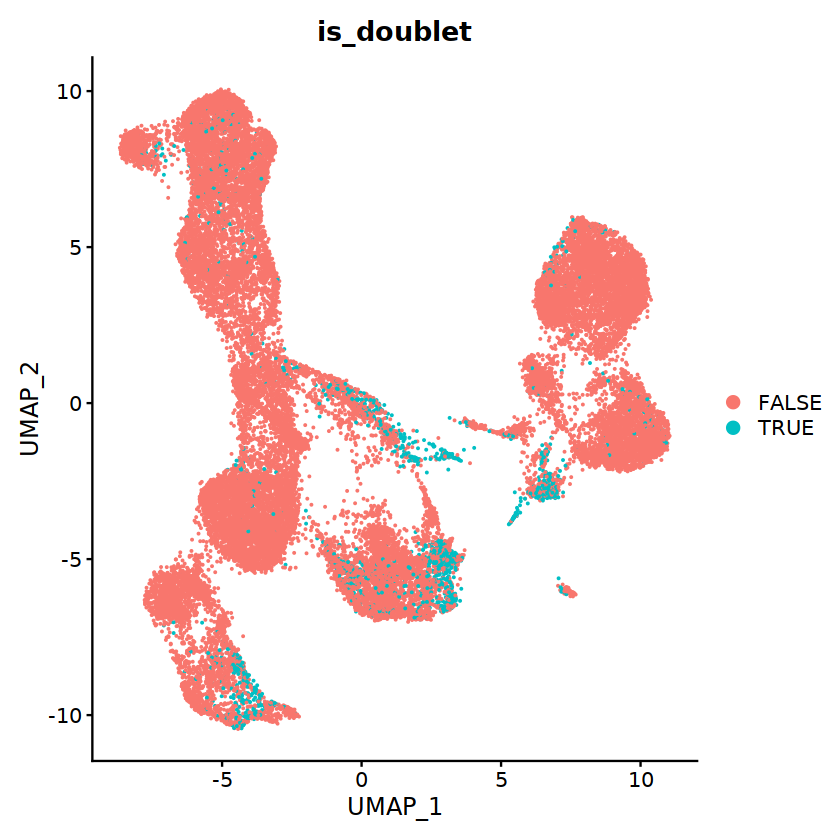

In [41]:
DimPlot(object = atac, label = FALSE, group.by='is_doublet') 

### Filter doublets

In [19]:
atac <- atac[, !atac$is_doublet]

In [20]:
atac

An object of class Seurat 
162003 features across 27506 samples within 1 assay 
Active assay: peaks (162003 features, 162003 variable features)

## Plot QC metrics

### Overview

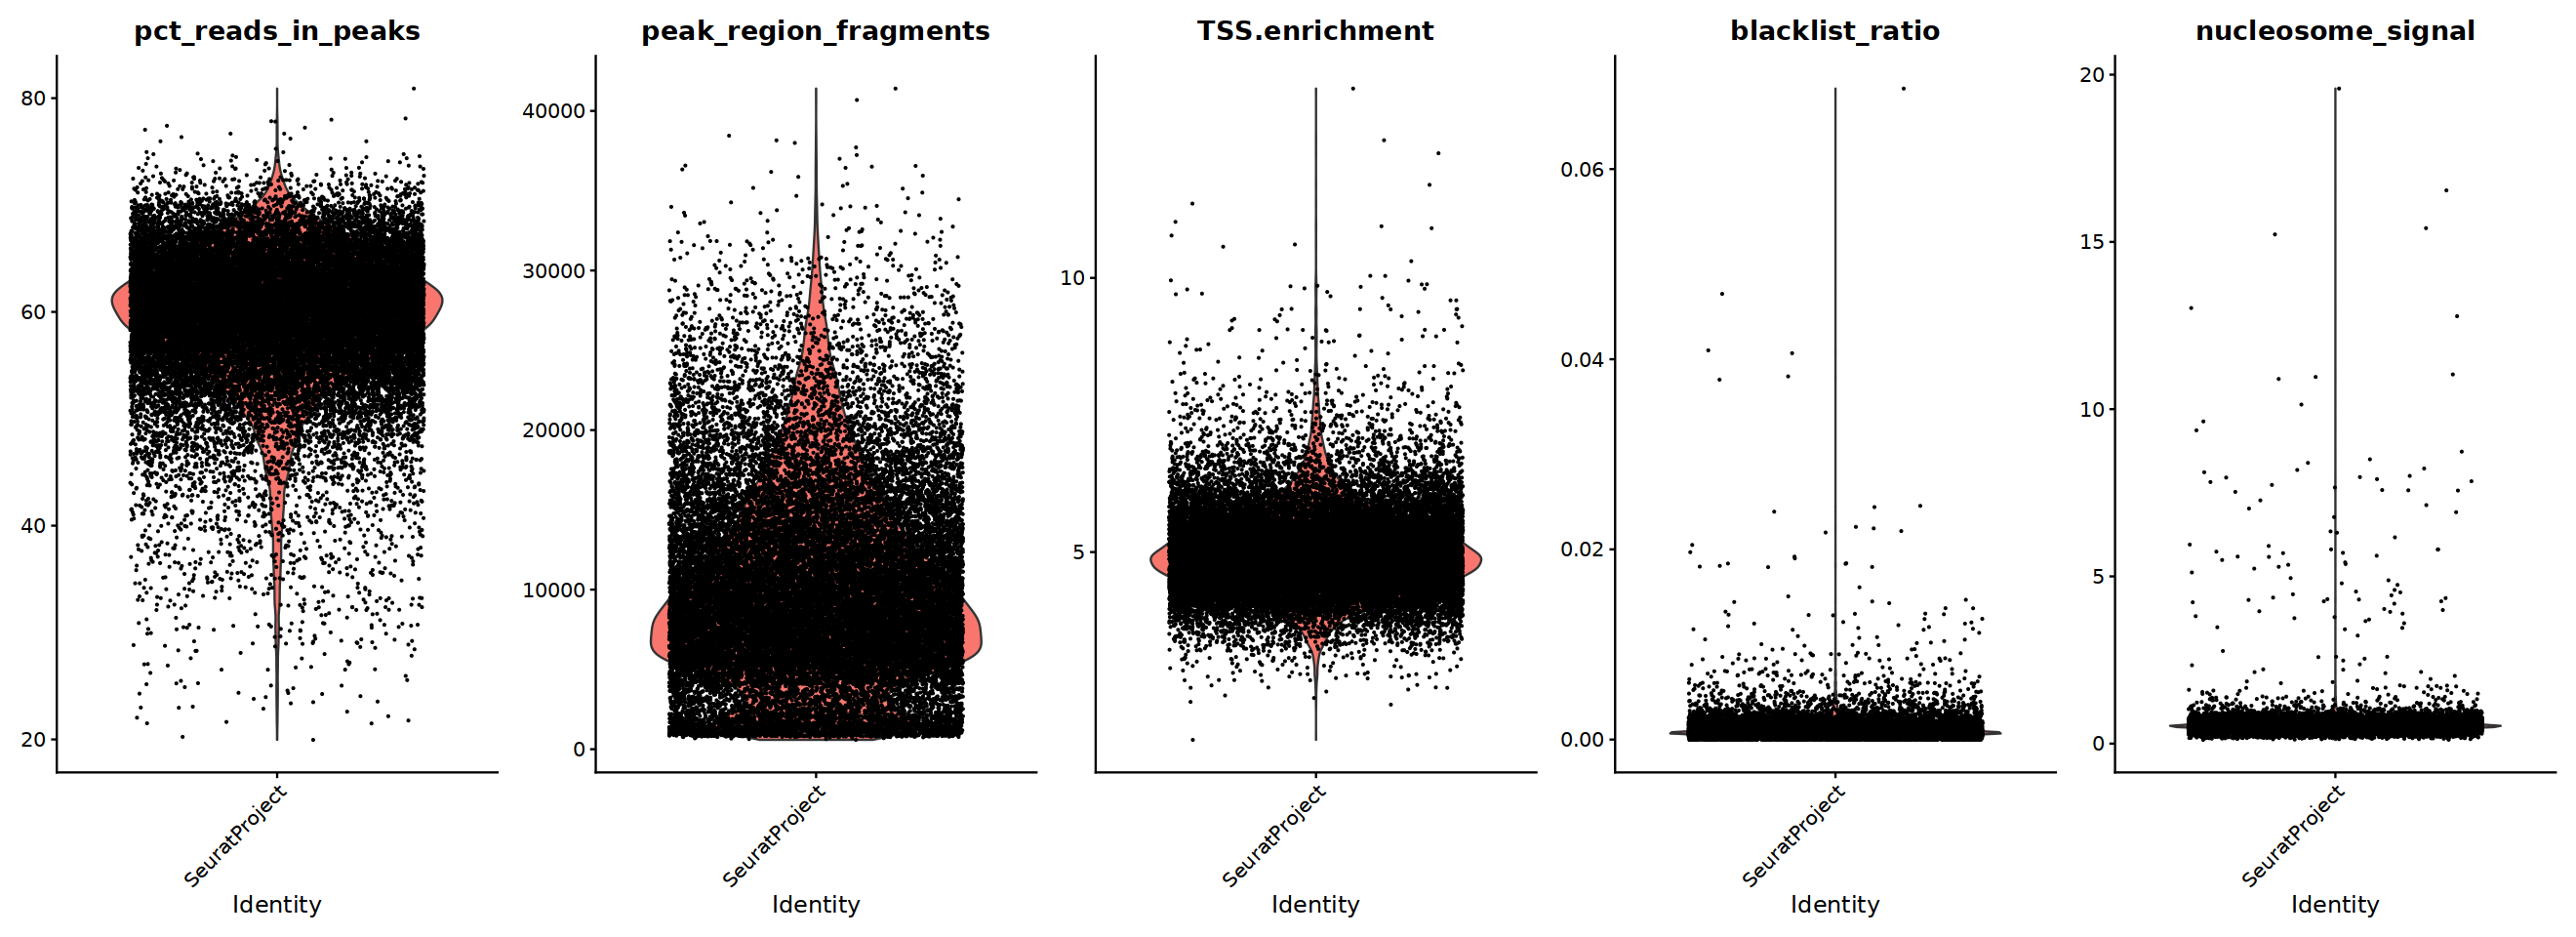

In [21]:
# overview of single metrics

options(repr.plot.width=22, repr.plot.height=8) # figure size


VlnPlot(
  object = atac,
  features = c('pct_reads_in_peaks', 'peak_region_fragments',
               'TSS.enrichment', 'blacklist_ratio', 'nucleosome_signal'),
  pt.size = 0.1,
  ncol = 5,
  group.by=NULL
)

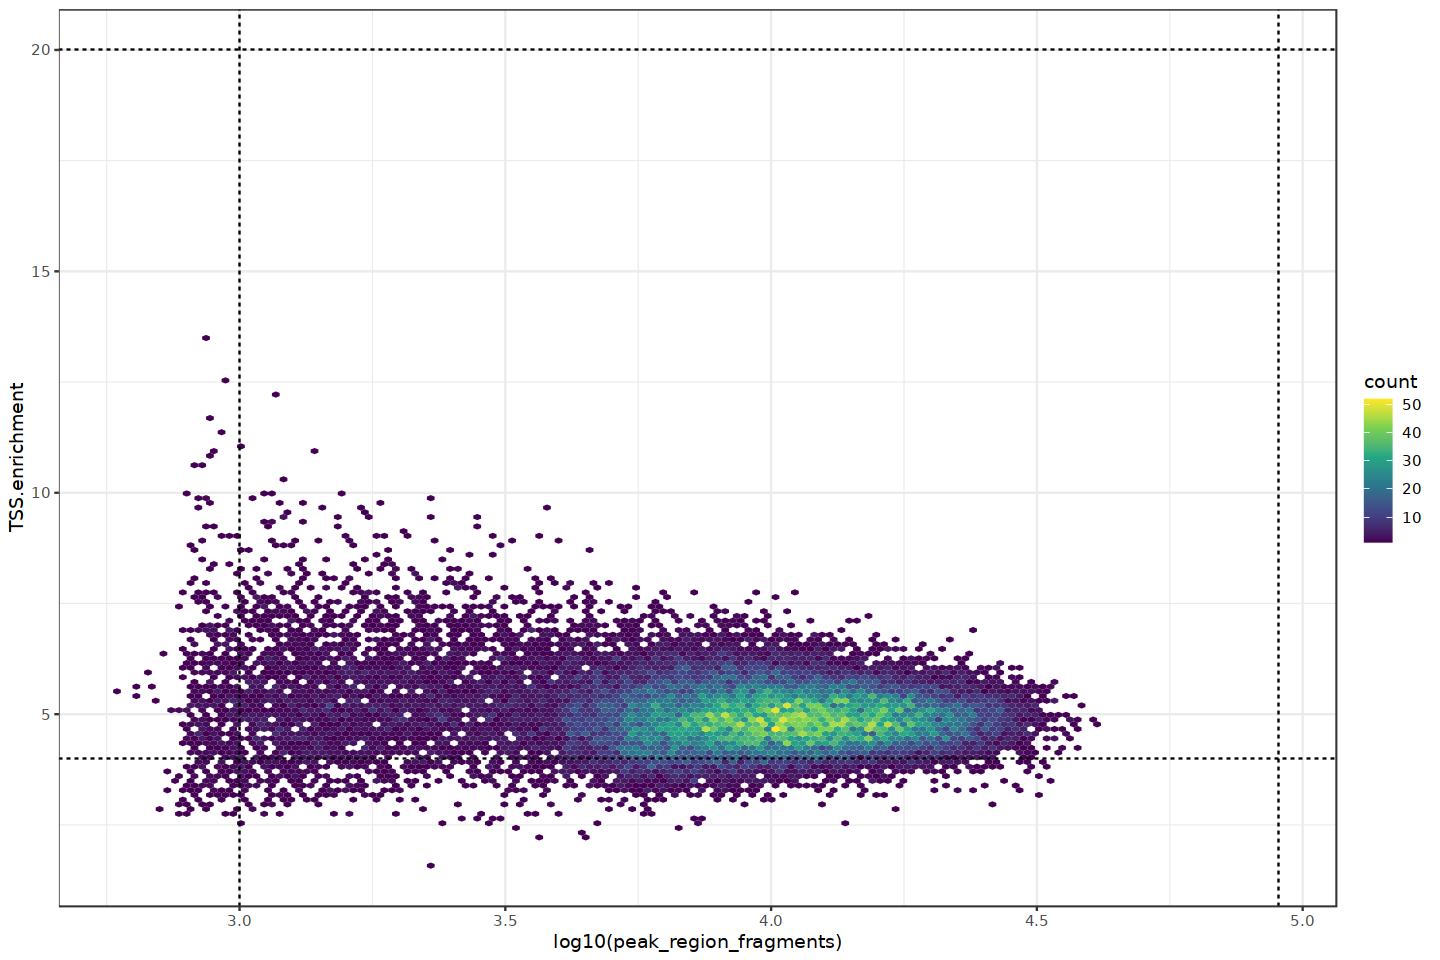

In [22]:
# log(fragments) vs TSS enrichment with potential cut-offs

options(repr.plot.width=12, repr.plot.height=8) # figure size

ggplot(atac@meta.data, aes(x=log10(peak_region_fragments), y=TSS.enrichment) ) +
  geom_hex(bins = 150) +
  scale_fill_continuous(type = "viridis") +
  theme_bw()+
  geom_hline(yintercept = 4, lty = "dashed") +
  geom_hline(yintercept = 20, lty = "dashed") +
  geom_vline(xintercept = log10(1000), lty = "dashed") +
  geom_vline(xintercept = log10(90000), lty = "dashed")

### Single metrics with cut-off decisions

Next, we plot each metric as a violin plot or histogram and decide suitable cut-offs.

In general, choose rather **permissive thresholds** since we have a downstreem QC step when combining modalities.

#### Total number of fragments

In [23]:
lower_totfraq_thresh = 10^(3)
upper_totfraq_thresh = 100000

In [24]:
# Reduce data to upper or lower part for plotting
lower_totfraqplot <- atac$peak_region_fragments[atac$peak_region_fragments < 2000]
upper_totfraqplot <- atac$peak_region_fragments[atac$peak_region_fragments > 25000 & atac$peak_region_fragments < 2*10**5]


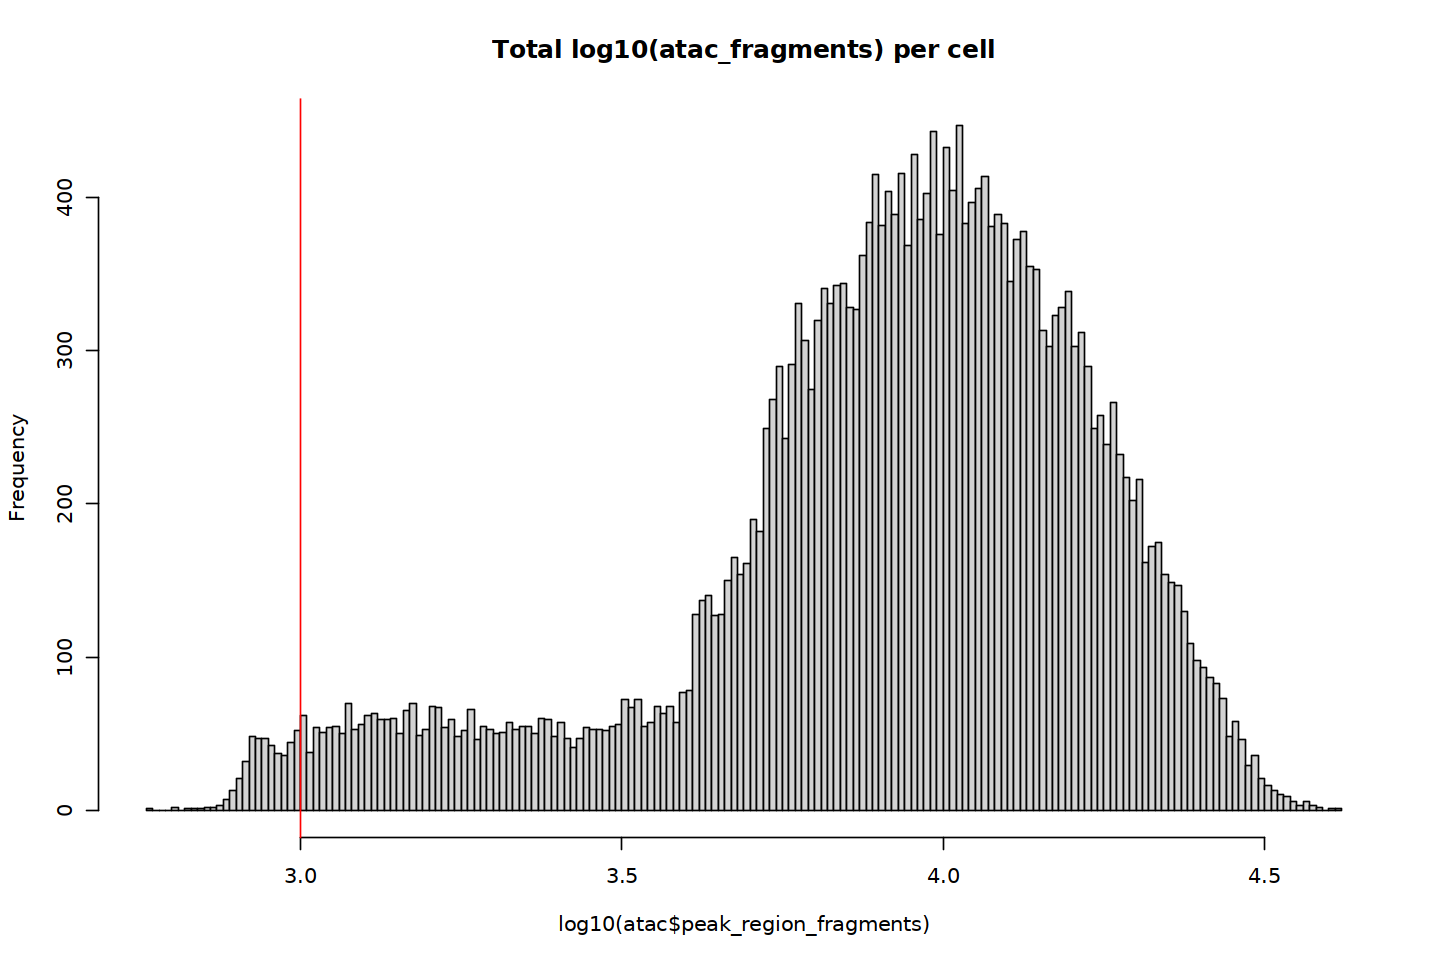

In [25]:
hist(log10(atac$peak_region_fragments), breaks = 150,
    main = 'Total log10(atac_fragments) per cell')
abline(v=log10(lower_totfraq_thresh), col = 'red')
abline(v=log10(upper_totfraq_thresh), col = 'red')

[1] "Removes 434 cells"


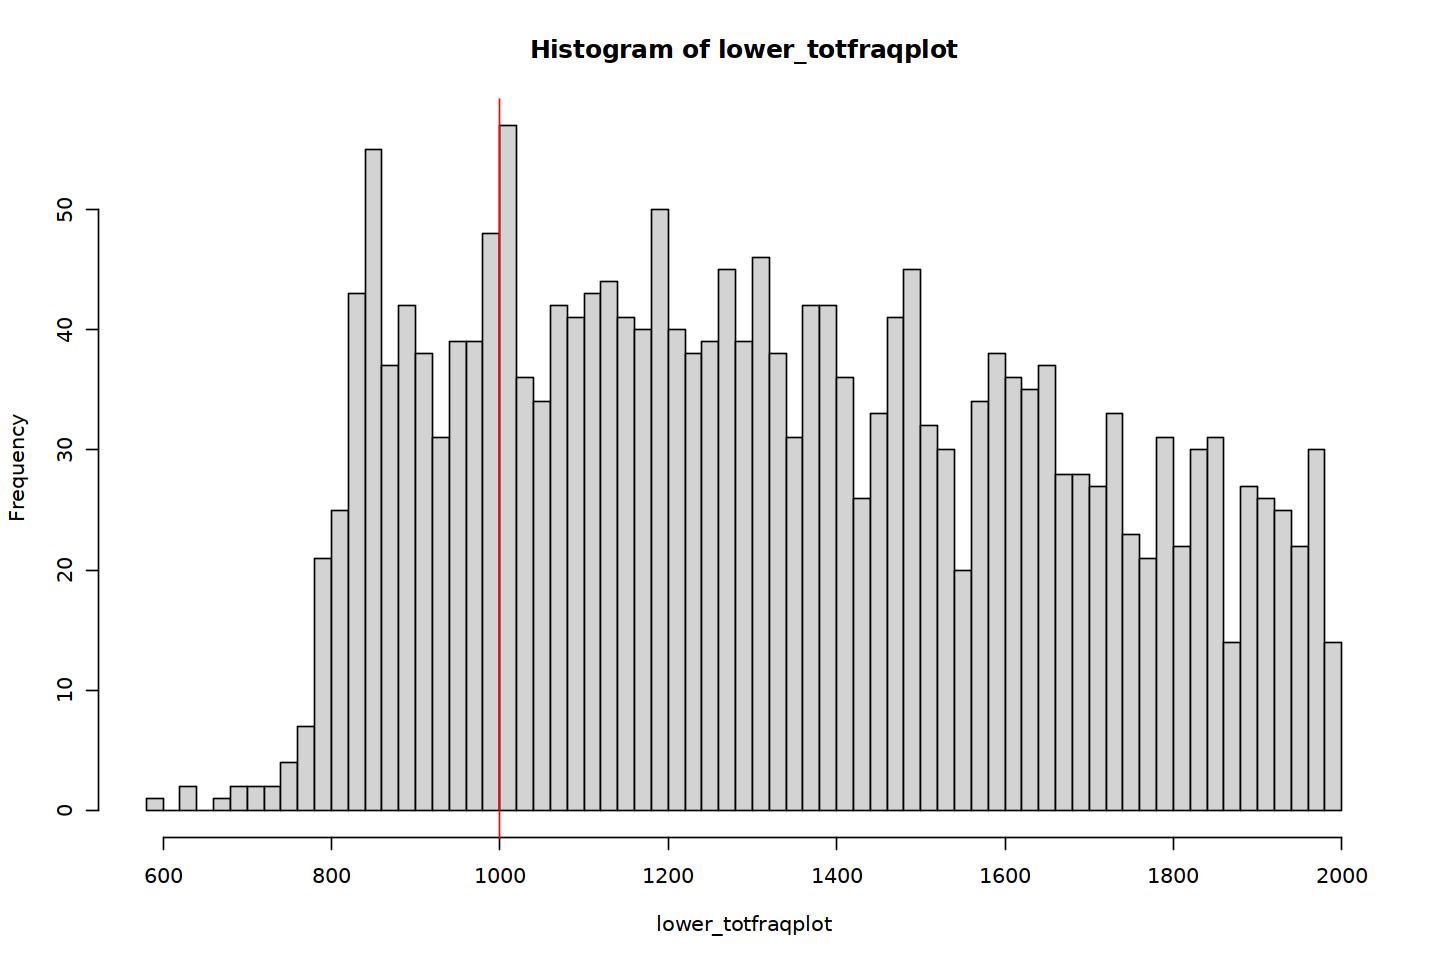

In [26]:
print(paste('Removes', as.character(sum(atac$peak_region_fragments < lower_totfraq_thresh)),'cells'))
hist(lower_totfraqplot, breaks = 100)
abline(v=lower_totfraq_thresh, col = 'red')

[1] "Removes 0 cells"


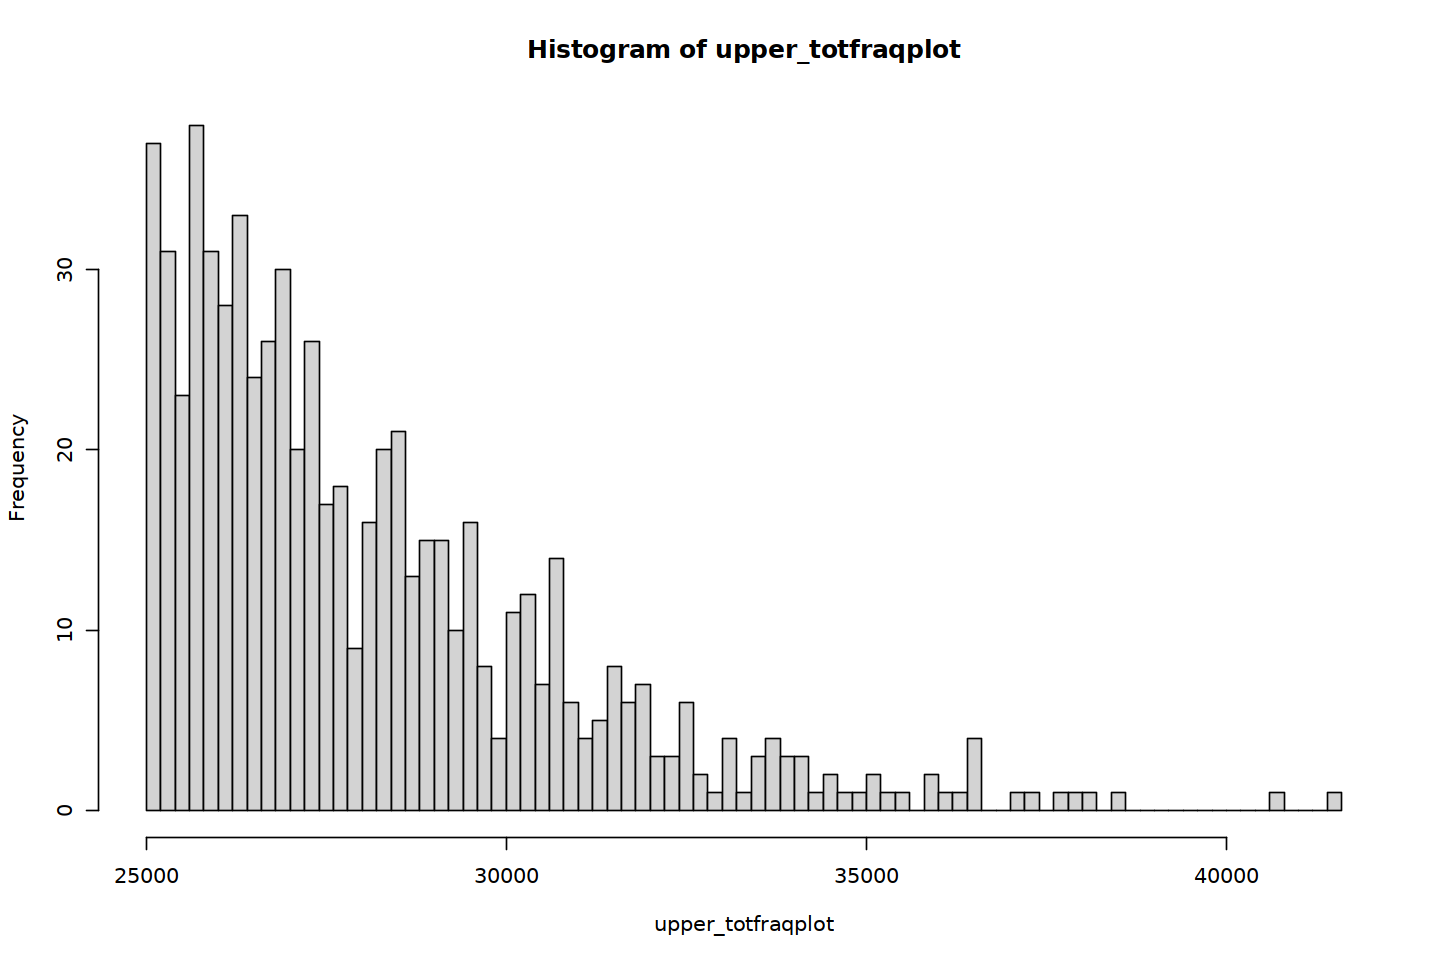

In [27]:
print(paste('Removes', as.character(sum(atac$peak_region_fragments > upper_totfraq_thresh)),'cells'))
hist(upper_totfraqplot, breaks = 100)
abline(v=upper_totfraq_thresh, col = 'red')

#### TSS enrichment

We don't consider a high TSS score as problematic, so we only filter for low and extreme high outliers

In [28]:
lower_tss_thresh = 2
upper_tss_thresh = 10

In [29]:
lower_tssplot <- atac$TSS.enrichment[atac$TSS.enrichment < 6]
upper_tssplot <- atac$TSS.enrichment[atac$TSS.enrichment > 5]

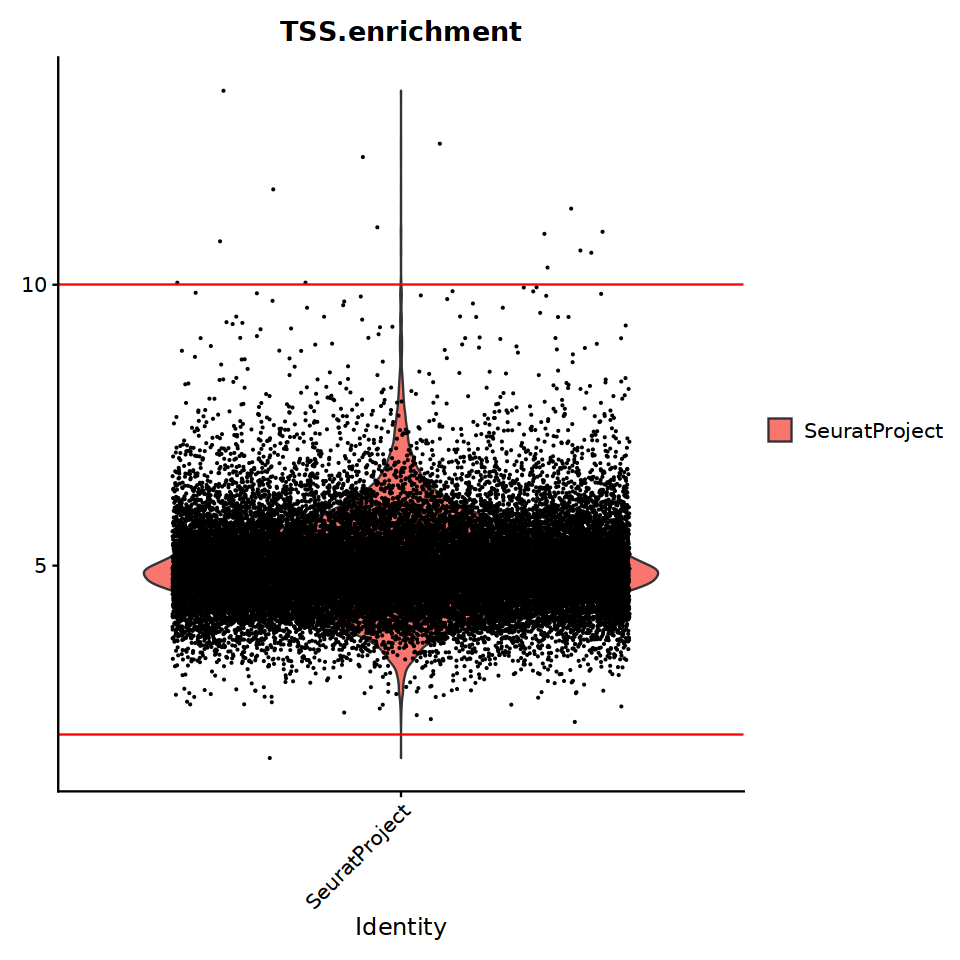

In [30]:
options(repr.plot.width=8, repr.plot.height=8) # figure size

v_plot <- VlnPlot(
    object = atac,
    features = c('TSS.enrichment'),
    pt.size = 0.1,
    ncol = 1,
)

v_plot + 
geom_hline(yintercept=lower_tss_thresh, color='red') +
geom_hline(yintercept=upper_tss_thresh, color='red') 

[1] "Removes 1 cells"


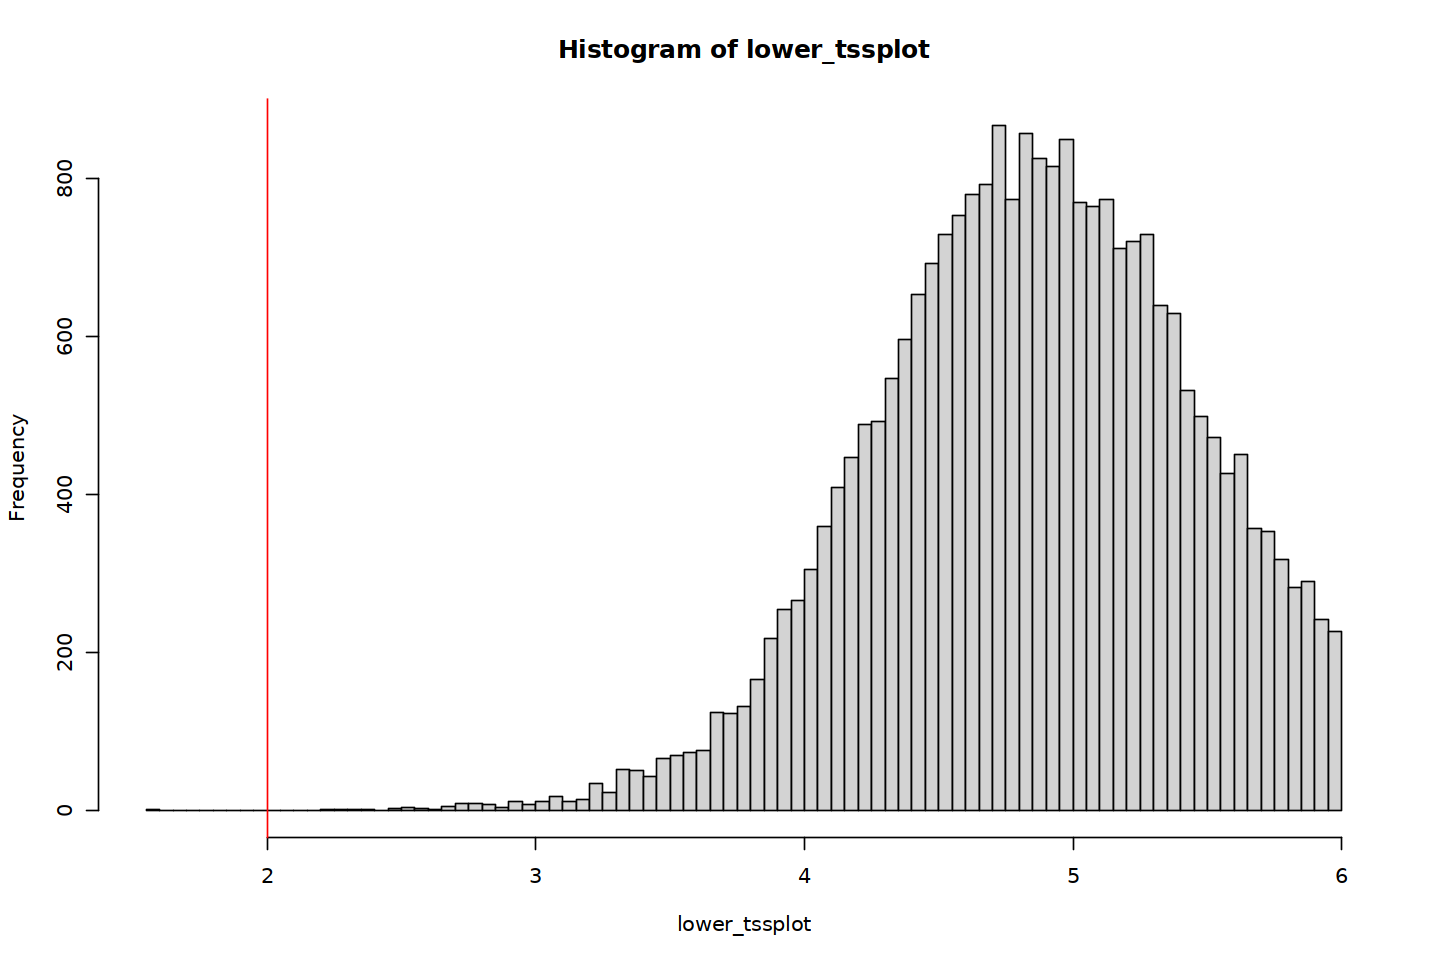

In [31]:
print(paste('Removes', as.character(sum(atac$TSS.enrichment < lower_tss_thresh)),'cells'))

options(repr.plot.width=12, repr.plot.height=8) # figure size

hist(lower_tssplot, breaks = 100)
abline(v=lower_tss_thresh, col = 'red')


[1] "Removes 14 cells"


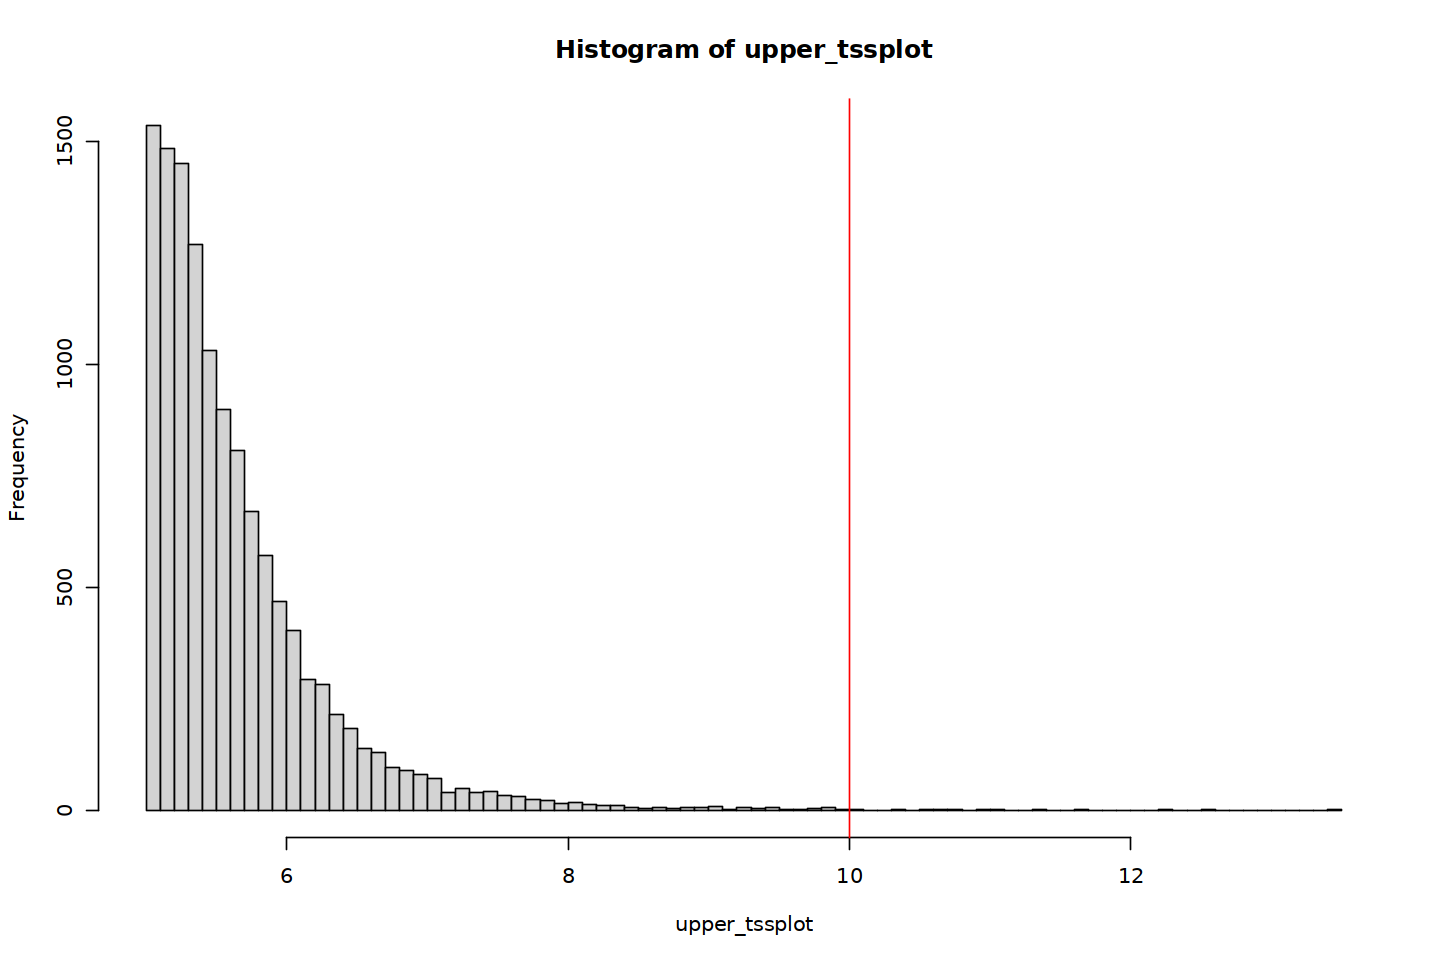

In [32]:
print(paste('Removes', as.character(sum(atac$TSS.enrichment > upper_tss_thresh)),'cells'))

options(repr.plot.width=12, repr.plot.height=8) # figure size

hist(upper_tssplot, breaks = 100)
abline(v=upper_tss_thresh, col = 'red')


#### Fraction of reads within peaks

Only remove lower tip

In [33]:
lower_in_peak_frac_thresh = 20

In [34]:
lower_in_peak_frac_plot <- atac$pct_reads_in_peaks[atac$pct_reads_in_peaks < 50]

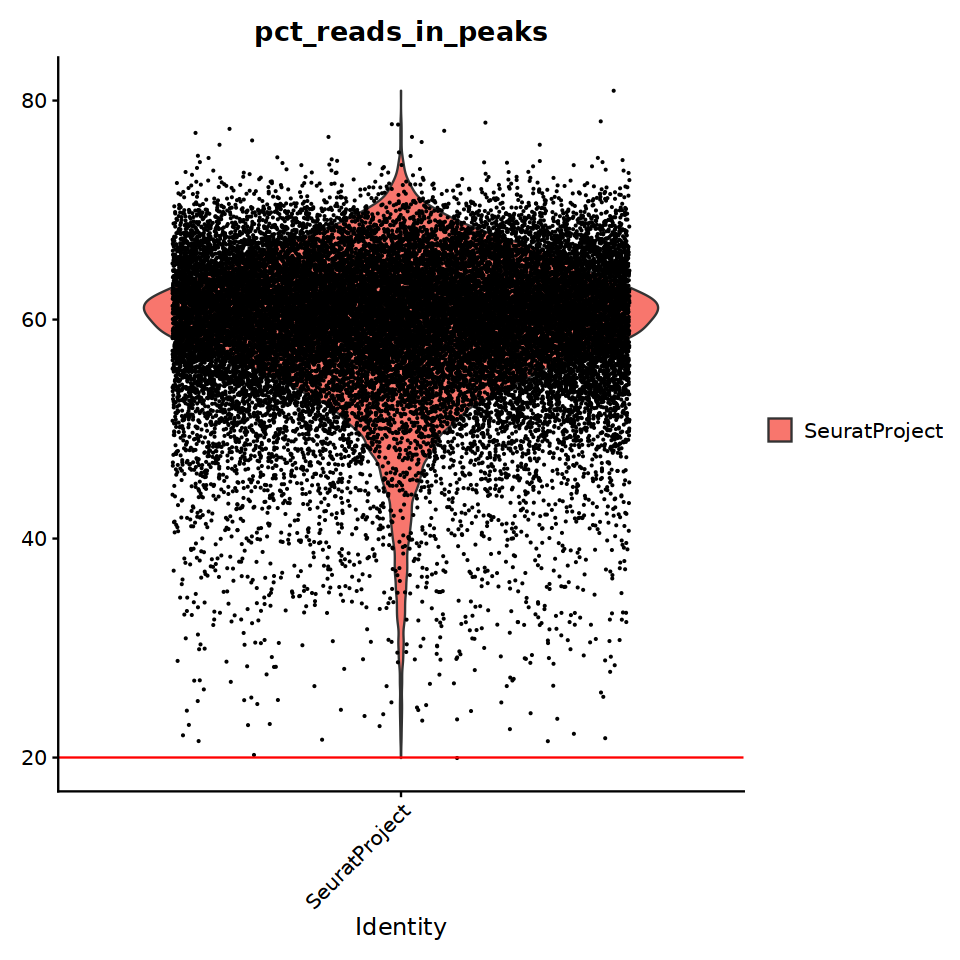

In [35]:
options(repr.plot.width=8, repr.plot.height=8) # figure size

v_plot <- VlnPlot(
    object = atac,
    features = c('pct_reads_in_peaks'),
    pt.size = 0.1,
    ncol = 1,
)

v_plot + 
geom_hline(yintercept=lower_in_peak_frac_thresh, color='red') 

[1] "Removes 1 cells"


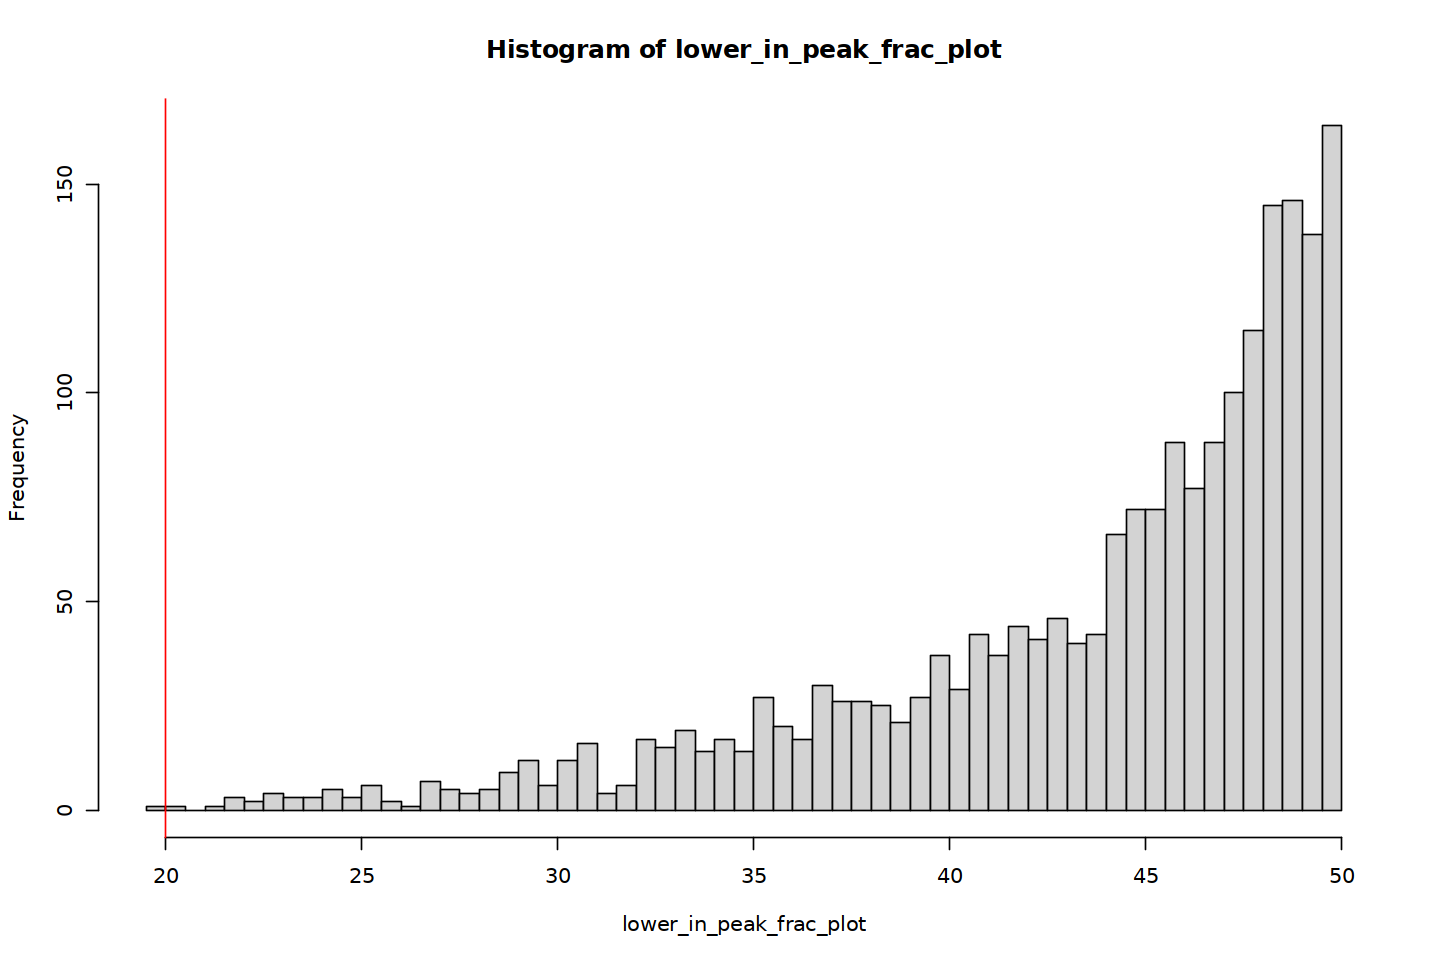

In [36]:
print(paste('Removes', as.character(sum(atac$pct_reads_in_peaks < lower_in_peak_frac_thresh)),'cells'))

options(repr.plot.width=12, repr.plot.height=8) # figure size

hist(lower_in_peak_frac_plot, breaks = 100)
abline(v=lower_in_peak_frac_thresh, col = 'red')


#### Blacklist fraction

Only remove upper tail

In [37]:
upper_bl_thresh = 0.015

In [38]:
upper_bl_plot <- atac$blacklist_ratio[atac$blacklist_ratio > 0.005 & atac$blacklist_ratio < 0.03]

Warning message:
"Removed 6 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 6 rows containing missing values (geom_point)."


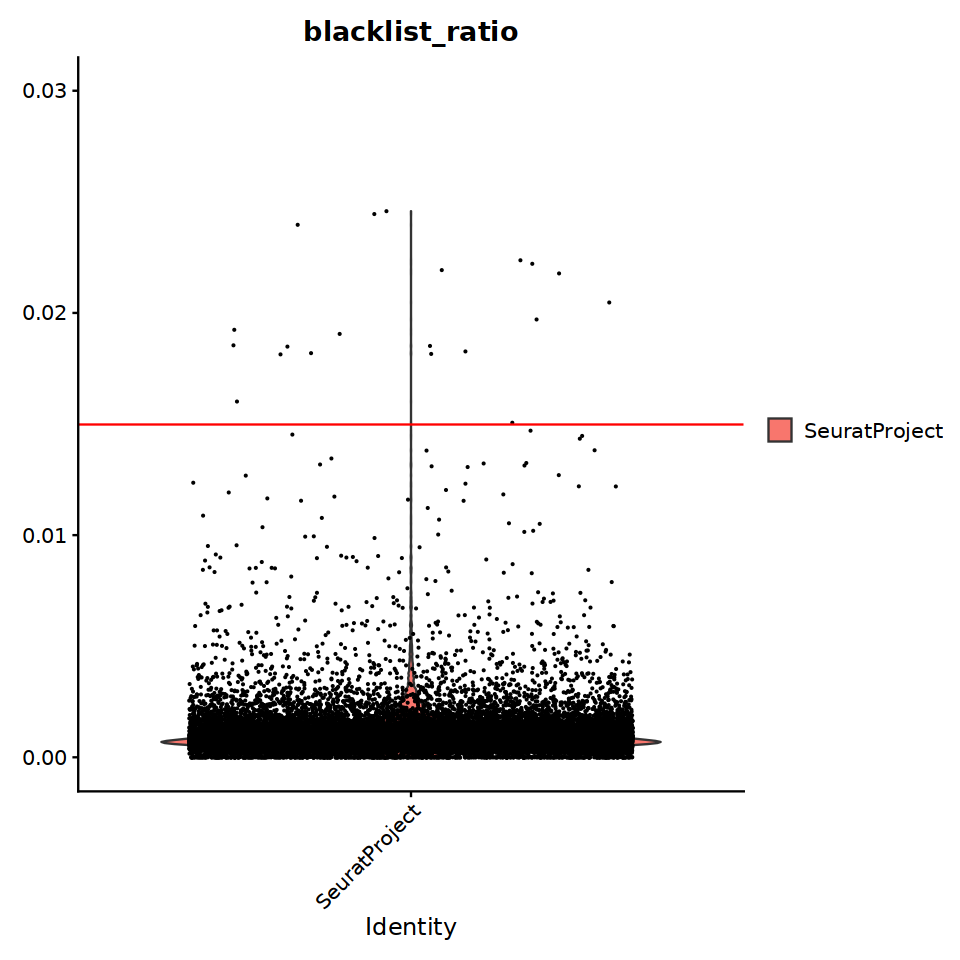

In [39]:
options(repr.plot.width=8, repr.plot.height=8) # figure size

v_plot <- VlnPlot(
    object = atac,
    features = c('blacklist_ratio'),
    pt.size = 0.1,
    ncol = 1,
    y.max = 0.03
)

v_plot + 
geom_hline(yintercept=upper_bl_thresh, color='red') 

[1] "Removes 26 cells"


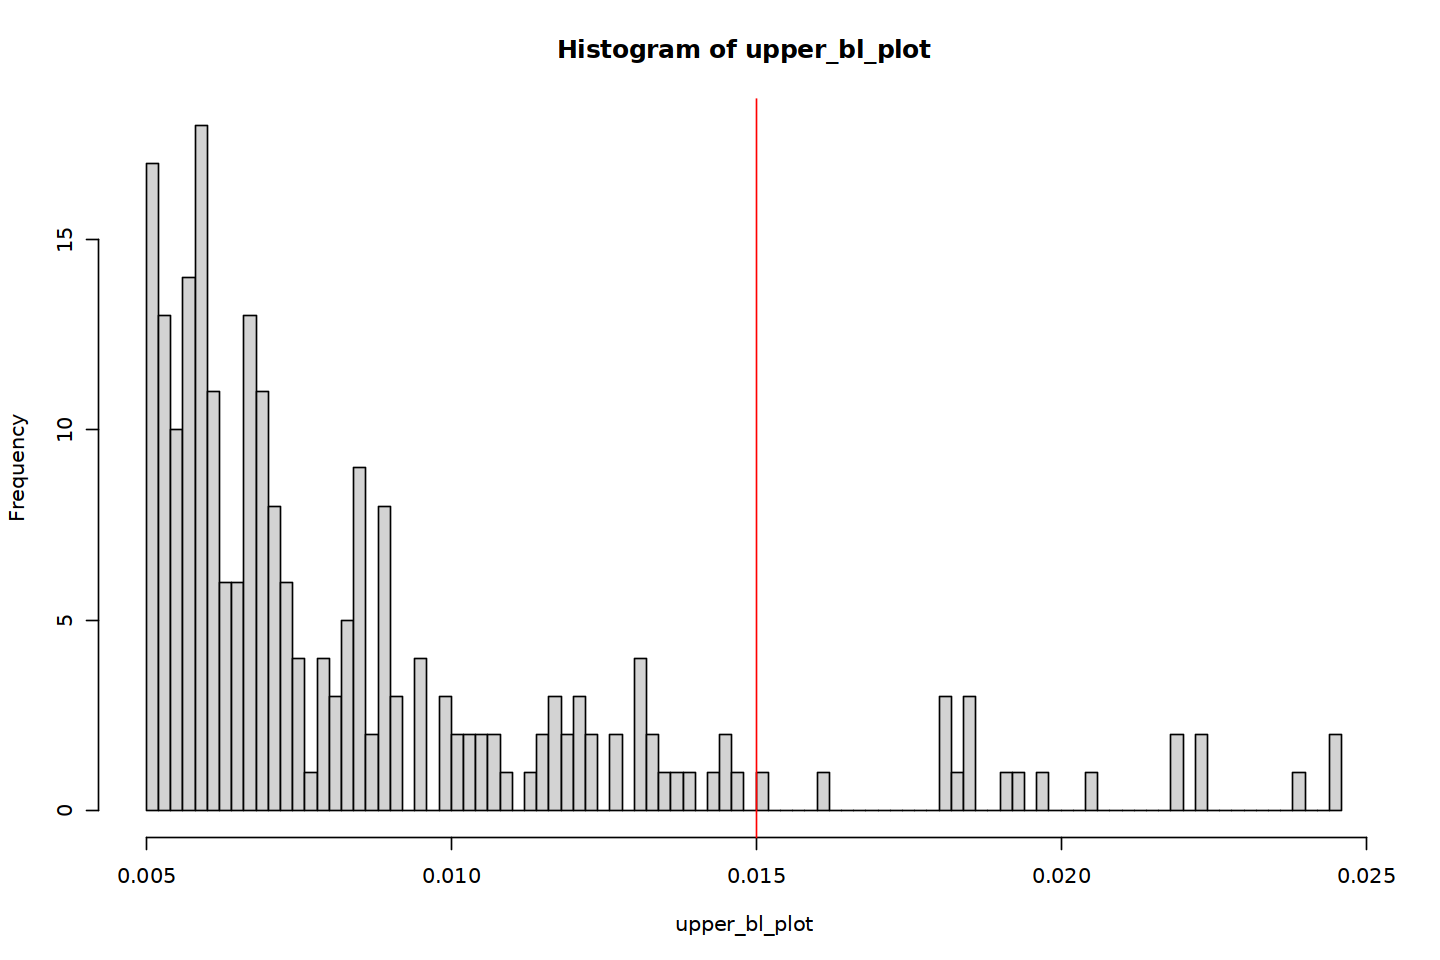

In [40]:
print(paste('Removes', as.character(sum(atac$blacklist_ratio > upper_bl_thresh)),'cells'))

options(repr.plot.width=12, repr.plot.height=8) # figure size

hist(upper_bl_plot, breaks = 100)
abline(v=upper_bl_thresh, col = 'red')


#### Nucleosome signal

Only remove upper tail

In [41]:
upper_ns_thresh = 10

In [42]:
upper_ns_plot <- atac$nucleosome_signal[atac$nucleosome_signal > 0.9]

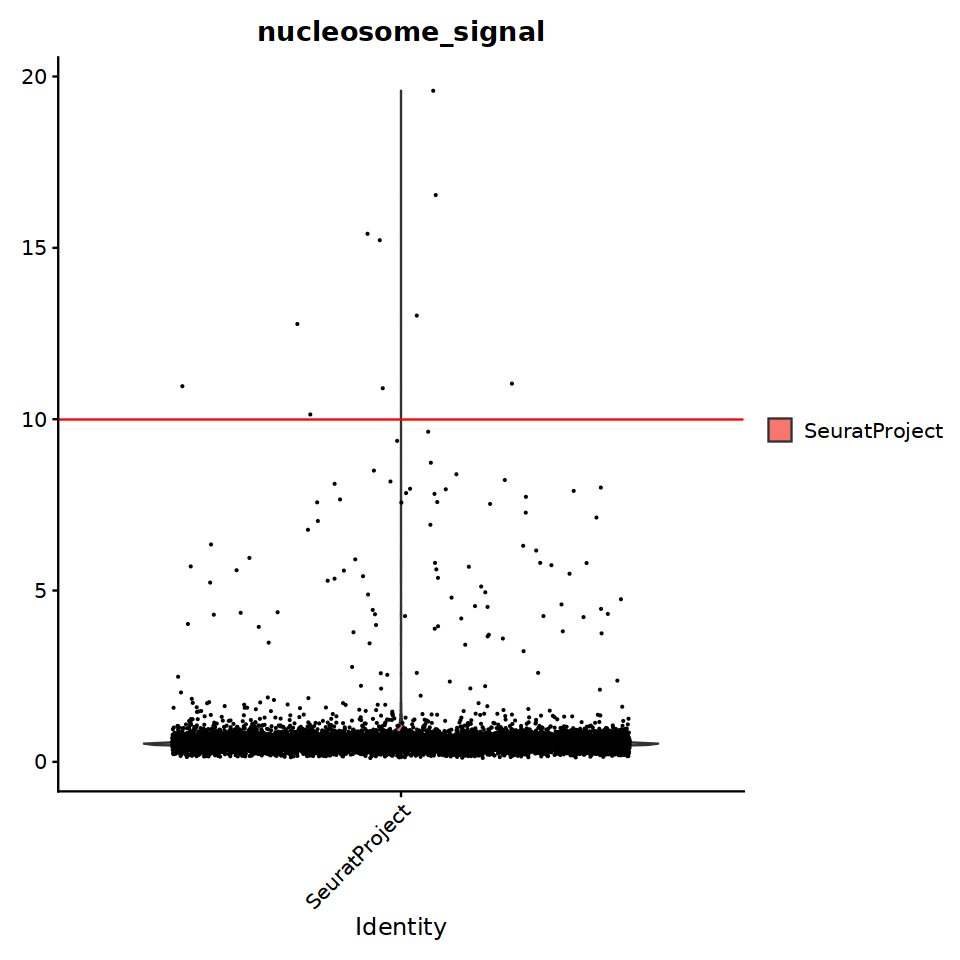

In [43]:
options(repr.plot.width=8, repr.plot.height=8) # figure size

v_plot <- VlnPlot(
    object = atac,
    features = c('nucleosome_signal'),
    pt.size = 0.1,
    ncol = 1
)

v_plot + 
geom_hline(yintercept=upper_ns_thresh, color='red') 

[1] "Removes 10 cells"


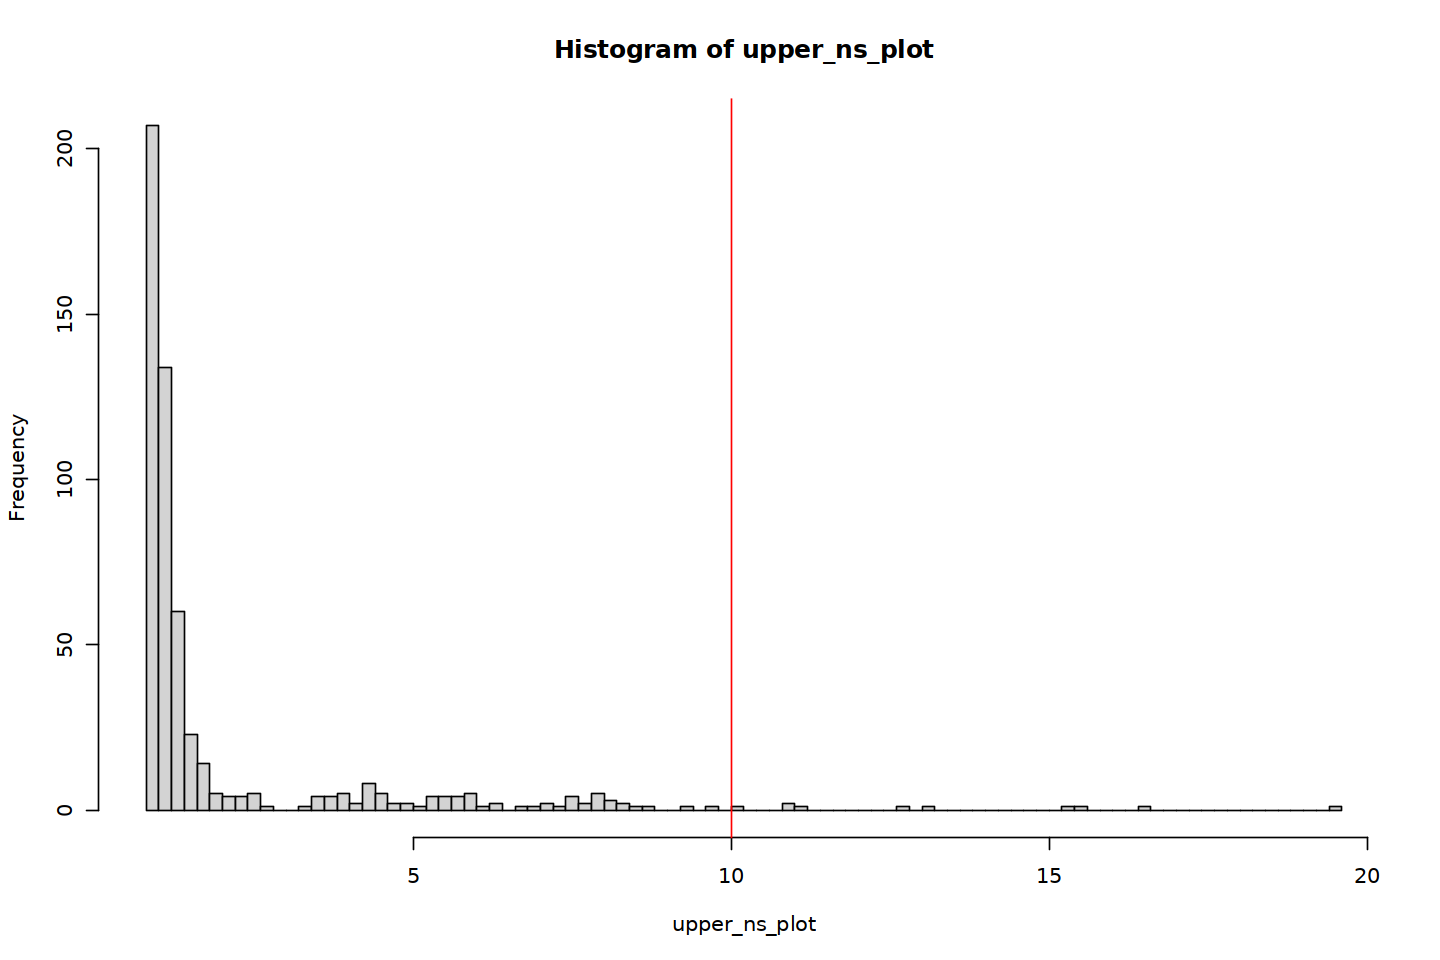

In [44]:
print(paste('Removes', as.character(sum(atac$nucleosome_signal > upper_ns_thresh)),'cells'))

options(repr.plot.width=12, repr.plot.height=8) # figure size

hist(upper_ns_plot, breaks = 100)
abline(v=upper_ns_thresh, col = 'red')


## Filter cells

To see how many cells are filtered after each step, the filters are applied sequentially.

In [45]:
# First filter atac object

n_before <- ncol(atac)
print(paste('Number of cells before filter step:', n_before))

atac_filtered <- subset(
    x = atac,
    subset = peak_region_fragments > lower_totfraq_thresh
)

n_after <- ncol(atac_filtered)
print(paste('Number of cells after filter step:', n_after))
print(paste('Percent removed', round((1 - n_after / n_before) * 100, 2),
            '% (', n_before - n_after, ')'))

[1] "Number of cells before filter step: 27506"
[1] "Number of cells after filter step: 27067"
[1] "Percent removed 1.6 % ( 439 )"


In [46]:
# Then use filtered object for subsequent filtering

n_before <- ncol(atac_filtered)
print(paste('Number of cells before filter step:', n_before))

atac_filtered <- subset(
    x = atac_filtered,
    subset = peak_region_fragments < upper_totfraq_thresh
)

n_after <- ncol(atac_filtered)
print(paste('Number of cells after filter step:', n_after))
print(paste('Percent removed', round((1 - n_after / n_before) * 100, 2),
            '% (', n_before - n_after, ')'))

[1] "Number of cells before filter step: 27067"
[1] "Number of cells after filter step: 27067"
[1] "Percent removed 0 % ( 0 )"


In [47]:
# TSS.enrichment

n_before <- ncol(atac_filtered)
print(paste('Number of cells before filter step:', n_before))

atac_filtered <- subset(
    x = atac_filtered,
    subset = TSS.enrichment > lower_tss_thresh &
        TSS.enrichment < upper_tss_thresh
)

n_after <- ncol(atac_filtered)
print(paste('Number of cells after filter step:', n_after))
print(paste('Percent removed', round((1 - n_after / n_before) * 100, 2),
            '% (', n_before - n_after, ')'))

[1] "Number of cells before filter step: 27067"
[1] "Number of cells after filter step: 27060"
[1] "Percent removed 0.03 % ( 7 )"


In [48]:
print(paste('Percent cells removed (total):', round((1-ncol(atac_filtered) / ncol(atac)) * 100, 2), '%'))

[1] "Percent cells removed (total): 1.62 %"


In [49]:
# reads_in_peaks_frac

n_before <- ncol(atac_filtered)
print(paste('Number of cells before filter step:', n_before))

atac_filtered <- subset(
    x = atac_filtered,
    subset = pct_reads_in_peaks > lower_in_peak_frac_thresh
)

n_after <- ncol(atac_filtered)
print(paste('Number of cells after filter step:', n_after))
print(paste('Percent removed', round((1 - n_after / n_before) * 100, 2),
            '% (', n_before - n_after, ')'))

[1] "Number of cells before filter step: 27060"
[1] "Number of cells after filter step: 27060"
[1] "Percent removed 0 % ( 0 )"


In [50]:
7

[1] 7

In [51]:
# blacklist_fraction

n_before <- ncol(atac_filtered)
print(paste('Number of cells before filter step:', n_before))

atac <- subset(
    x = atac_filtered,
    subset = blacklist_ratio < upper_bl_thresh
)

n_after <- ncol(atac)
print(paste('Number of cells after filter step:', n_after))
print(paste('Percent removed', round((1 - n_after / n_before) * 100, 2),
            '% (', n_before - n_after, ')'))

[1] "Number of cells before filter step: 27060"
[1] "Number of cells after filter step: 27037"
[1] "Percent removed 0.08 % ( 23 )"


In [52]:
# reads_in_peaks_frac

n_before <- ncol(atac_filtered)
print(paste('Number of cells before filter step:', n_before))

atac_filtered <- subset(
    x = atac,
    subset = nucleosome_signal < upper_ns_thresh
)

n_after <- ncol(atac_filtered)
print(paste('Number of cells after filter step:', n_after))
print(paste('Percent removed', round((1 - n_after / n_before) * 100, 2),
            '% (', n_before - n_after, ')'))

[1] "Number of cells before filter step: 27060"
[1] "Number of cells after filter step: 27027"
[1] "Percent removed 0.12 % ( 33 )"


In [53]:
print(paste('Percent cells removed (total):', round((1-ncol(atac_filtered) / ncol(atac)) * 100, 2), '%'))

[1] "Percent cells removed (total): 0.04 %"


In [54]:
atac_filtered

An object of class Seurat 
162003 features across 27027 samples within 1 assay 
Active assay: peaks (162003 features, 162003 variable features)

## Dimensionality reduction via LSI

Perfom latent sematic indexing (LSI) by generating term frequencies and SVD on these. LSI is adapted from NLP to identify similar documents. See some further details here: https://en.wikipedia.org/wiki/Latent_semantic_analysis#Latent_semantic_indexing


In [55]:
atac_filtered <- RunTFIDF(atac_filtered)

Performing TF-IDF normalization



In [56]:
atac_filtered <- FindTopFeatures(atac_filtered, min.cutoff = 'q0')

In [57]:
atac_filtered <- RunSVD(atac_filtered)

Running SVD

Scaling cell embeddings



In [58]:
options(repr.plot.width=16, repr.plot.height=9)

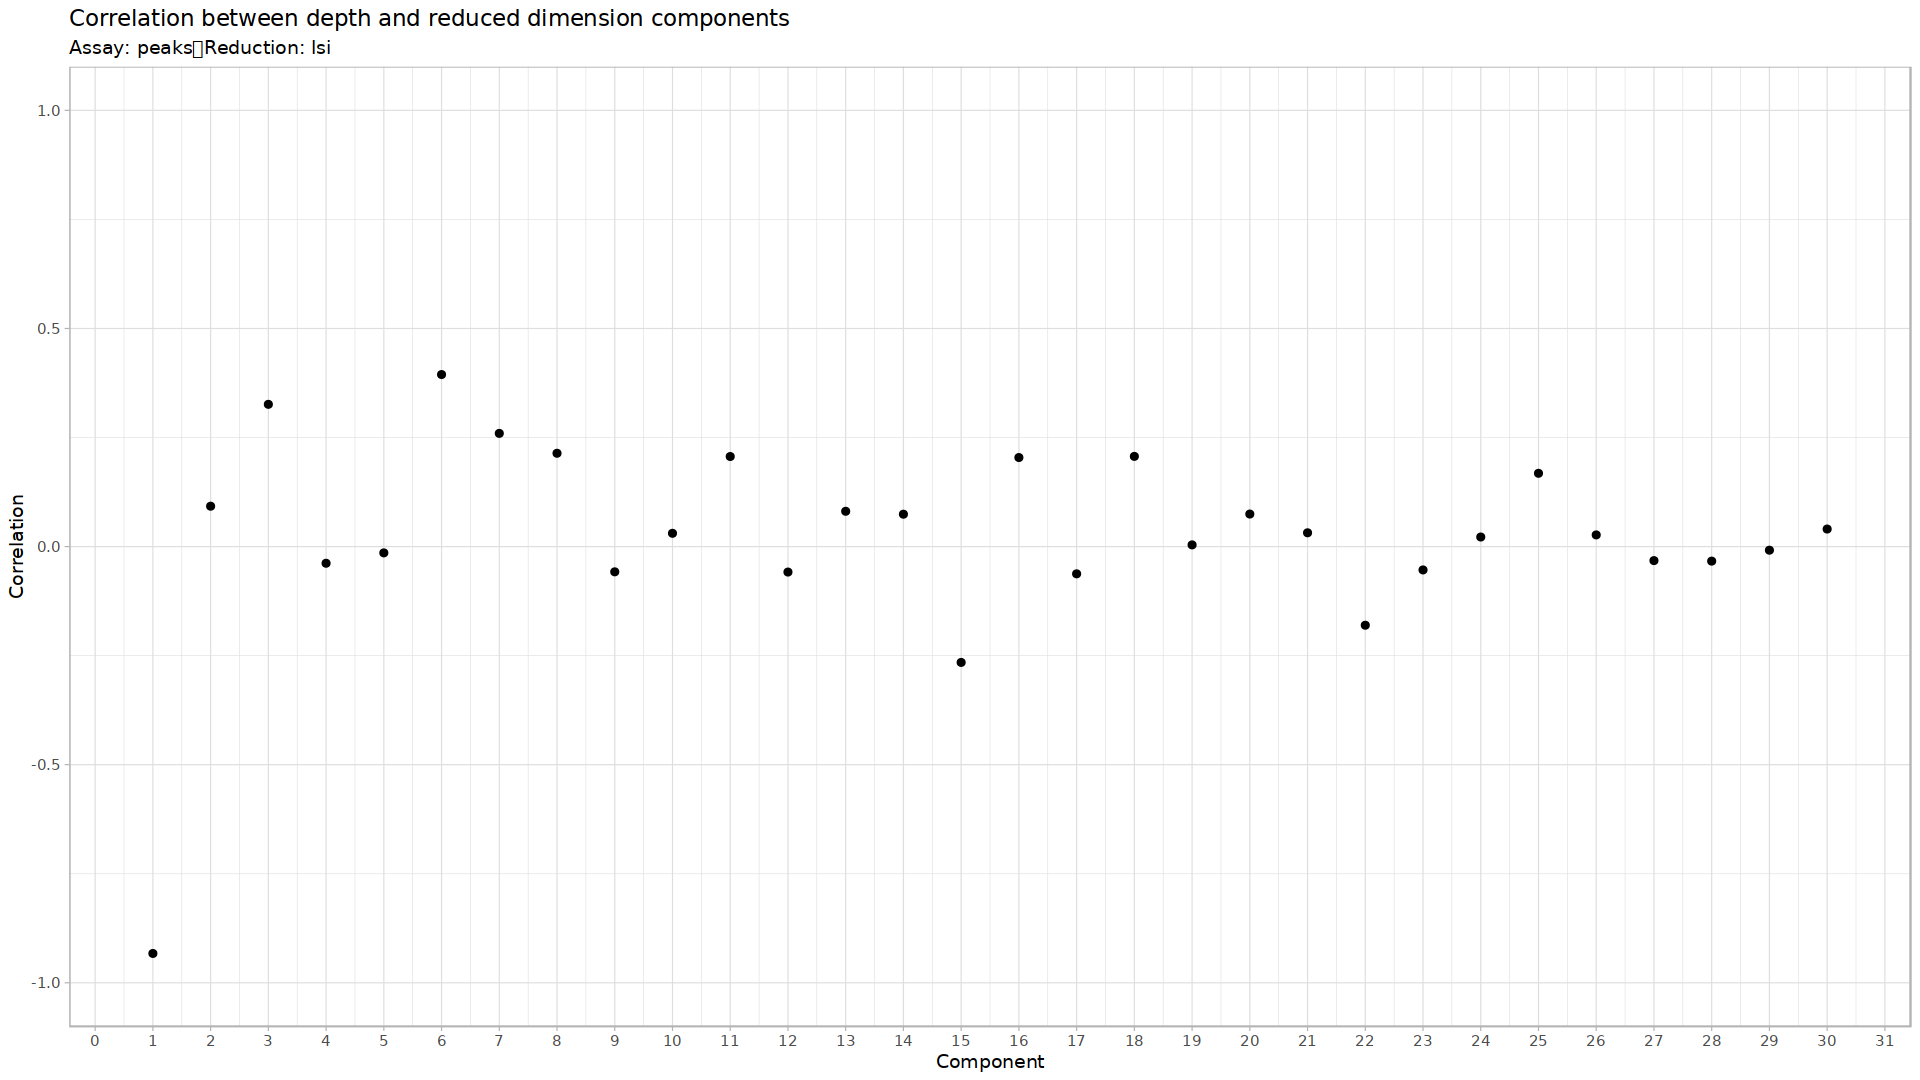

In [59]:
DepthCor(atac_filtered, n=30) 

**^^Plot above:** The first and sometimes few more LSI components are highly correlated to the total fragment count per cell (here, also refered to as sequencing depth). For downstream processing we would like to remove these components and work with the variance captured by the remaining components. In the plot below, the first component is nearly perfectly correlated with the sequencing depth per cell. Also the 4th component might be good to be removed.

## Save intermediate output

In [56]:
#saveRDS(atac_filtered, file ='/lustre/groups/ml01/workspace/laura.martens/moretti_colab/signac/atac_fltr.rds')
atac_filtered <- readRDS(file ='/lustre/groups/ml01/workspace/laura.martens/moretti_colab/signac/atac_fltr.rds')

## Remove LSI components

To test the effect on the downstream processing, we create a neighborhood graph based on the components not correlated with the sequencing depth, cluster the cells and visualize our qc metrics on the data.

The goal is to remove LSI components that are highly correlated with the total number of fragments while keeping as much structure as possible.

For illustration purpose, we also perform clustering using all components. One can nicely see how this is driven by the number of atac_fragments (especially low counts).

Further points to consider when choosing components to remove:
- Often removing 1 or 2 components is enough
- A high count cluster might correlate with doublets, so removing all total count-driven variation can make separation of doublets/low quality cells more difficult (See plot with 1st, 2nd and 4th component removed)
- 50 LSI components were generated, 30 - 45 should be sufficient to include in total
- Despite removing total count-related LSI components, it is expected to see a high and/or low count cluster that might be sprinkeld across the UMAP. This we need to take care of during annotation (ATAC notebook part 2).


### With all components

In [57]:
# Defining, which components to keep:
dims_to_use <- c(1:40)

In [58]:
atac_fltr_all <- suppressMessages(RunUMAP(object = atac_filtered, reduction = 'lsi', dims = dims_to_use))

In [59]:
atac_fltr_all <- FindNeighbors(object = atac_fltr_all, reduction = 'lsi', dims = dims_to_use)

Computing nearest neighbor graph

Computing SNN



In [60]:
atac_fltr_all <- FindClusters(object = atac_fltr_all, verbose = FALSE, algorithm = 3)

In [61]:
options(repr.plot.width=24, repr.plot.height=12)

In [62]:
dimplot1 <- DimPlot(object = atac_fltr_all, label = TRUE) + NoLegend()

In [63]:
atac_fltr_all$sample = str_split(Cells(atac_fltr_all), '-', simplify=TRUE)[,2]

In [64]:
dimplot2 <- DimPlot(object = atac_fltr_all, label = TRUE, group.by='sample') + NoLegend()

In [65]:
peak_frac_pl <- FeaturePlot(
  object = atac_fltr_all,
  features = 'peak_region_fragments',
  pt.size = 0.1
) + ggtitle("atac_fragments - high counts highlighted")

In [66]:
peak_frac_low_pl <- FeaturePlot(
  object = atac_fltr_all,
  features = 'peak_region_fragments',
  pt.size = 0.1,
  max.cutoff=4000,
  cols = c("darkred", "lightgrey")
) + ggtitle("atac_fragments - low counts highlighted")

In [67]:
tss_pl <- FeaturePlot(
  object = atac_fltr_all,
  features = 'TSS.enrichment',
  pt.size = 0.1,
  max.cutoff=6,
  cols = c("darkred", "lightgrey")
)

In [68]:
per_in_peak_pl <- FeaturePlot(
  object = atac_fltr_all,
  features = 'pct_reads_in_peaks',
  pt.size = 0.1,
  max.cutoff=60,
  cols = c("darkred", "lightgrey")
)

In [69]:
bl_pl <- FeaturePlot(
  object = atac_fltr_all,
  features = 'blacklist_ratio',
  pt.size = 0.1,
  max.cutoff=0.01
) 

In [70]:
ns_pl <- FeaturePlot(
  object = atac_fltr_all,
  features = 'nucleosome_signal',
  pt.size = 0.1,
  min.cutoff=3
) 

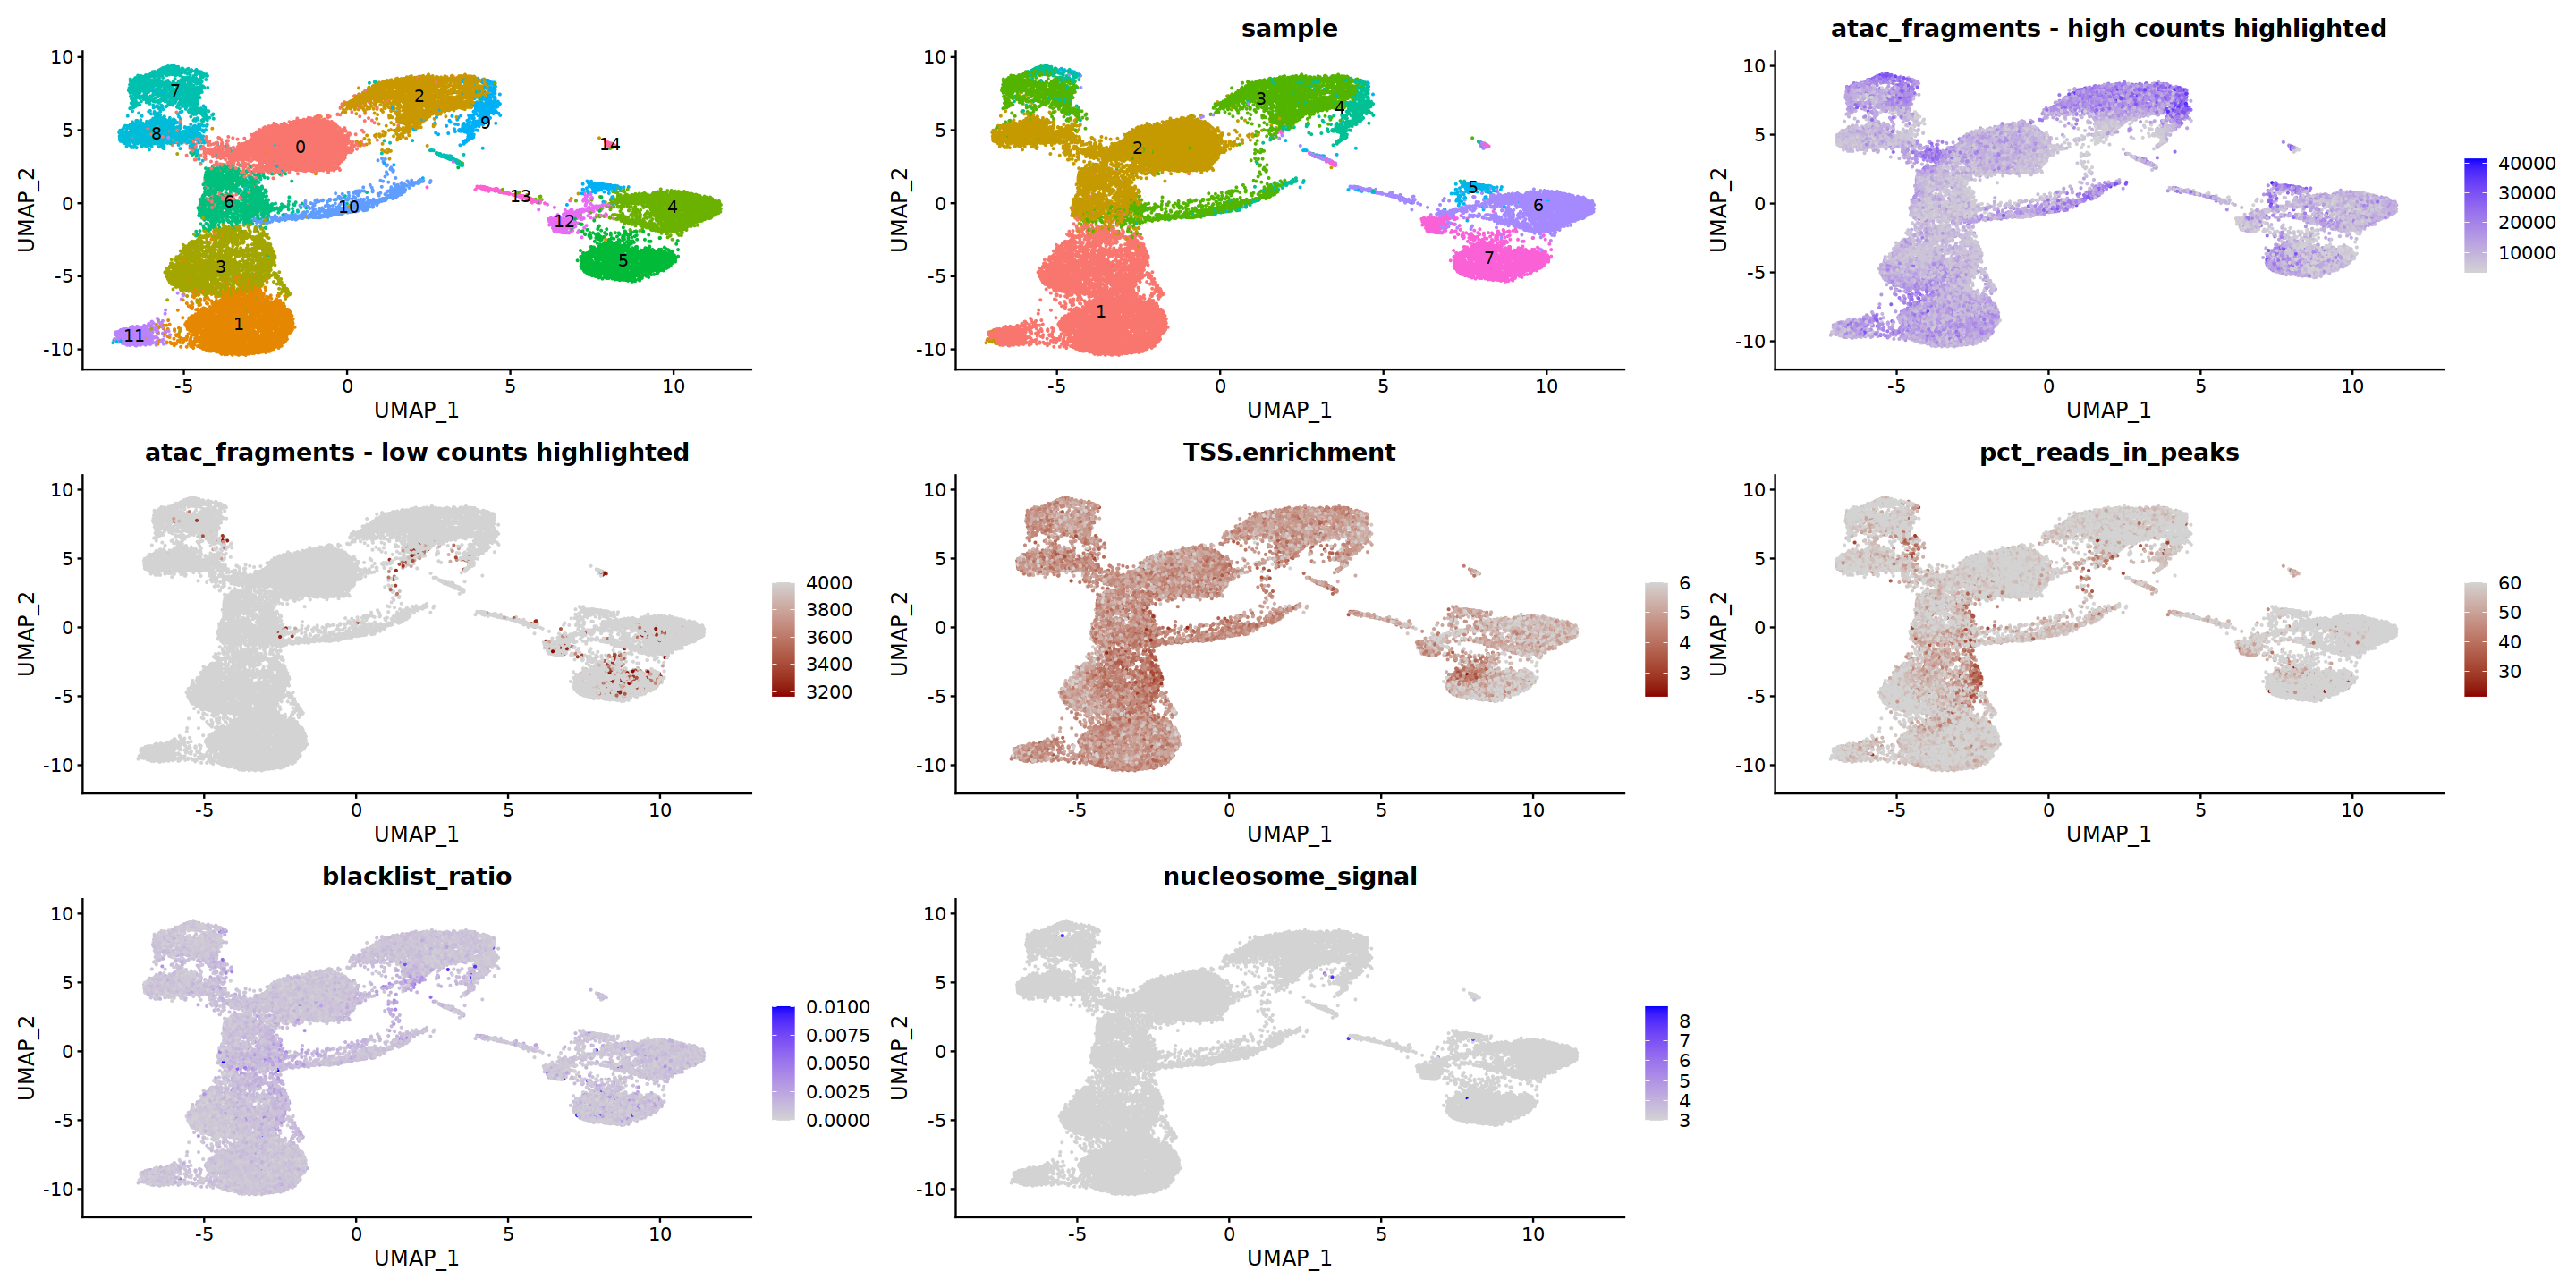

In [71]:
dimplot1 + dimplot2 + peak_frac_pl + peak_frac_low_pl + tss_pl + per_in_peak_pl + bl_pl + ns_pl

**^^Plot above:** Structure mainly driven by total counts (small number of counts)

### Removing only the first LSI component

In [60]:
# Defining, which components to keep:
dims_to_use <- c(2:40)

In [61]:
atac_fltr_1 <- suppressMessages(RunUMAP(object = atac_filtered, reduction = 'lsi', dims = dims_to_use))

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"


In [62]:
atac_fltr_1 <- FindNeighbors(object = atac_fltr_1, reduction = 'lsi', dims = dims_to_use)

Computing nearest neighbor graph

Computing SNN



In [63]:
atac_fltr_1 <- FindClusters(object = atac_fltr_1, verbose = FALSE, algorithm = 3)

In [64]:
options(repr.plot.width=24, repr.plot.height=12)

In [65]:
dimplot1 <- DimPlot(object = atac_fltr_1, label = TRUE) + NoLegend()

In [66]:
atac_fltr_1$sample = str_split(Cells(atac_fltr_1), '-', simplify=TRUE)[,2]

In [67]:
dimplot2 <- DimPlot(object = atac_fltr_1, label = TRUE, group.by='sample') + NoLegend()

In [68]:
peak_frac_pl <- FeaturePlot(
  object = atac_fltr_1,
  features = 'peak_region_fragments',
  pt.size = 0.1,
  max.cutoff=100000
)

In [69]:
peak_frac_low_pl <- FeaturePlot(
  object = atac_fltr_1,
  features = 'peak_region_fragments',
  pt.size = 0.1,
  max.cutoff=4000,
  cols = c("darkred", "lightgrey")
)

In [70]:
tss_pl <- FeaturePlot(
  object = atac_fltr_1,
  features = 'TSS.enrichment',
  pt.size = 0.1,
  max.cutoff=6,
  cols = c("darkred", "lightgrey")
)

In [71]:
per_in_peak_pl <- FeaturePlot(
  object = atac_fltr_1,
  features = 'pct_reads_in_peaks',
  pt.size = 0.1,
  max.cutoff=60,
  cols = c("darkred", "lightgrey")
)

In [72]:
bl_pl <- FeaturePlot(
  object = atac_fltr_1,
  features = 'blacklist_ratio',
  pt.size = 0.1,
  max.cutoff=0.01
) 

In [73]:
ns_pl <- FeaturePlot(
  object = atac_fltr_1,
  features = 'nucleosome_signal',
  pt.size = 0.1,
  min.cutoff=3
) 

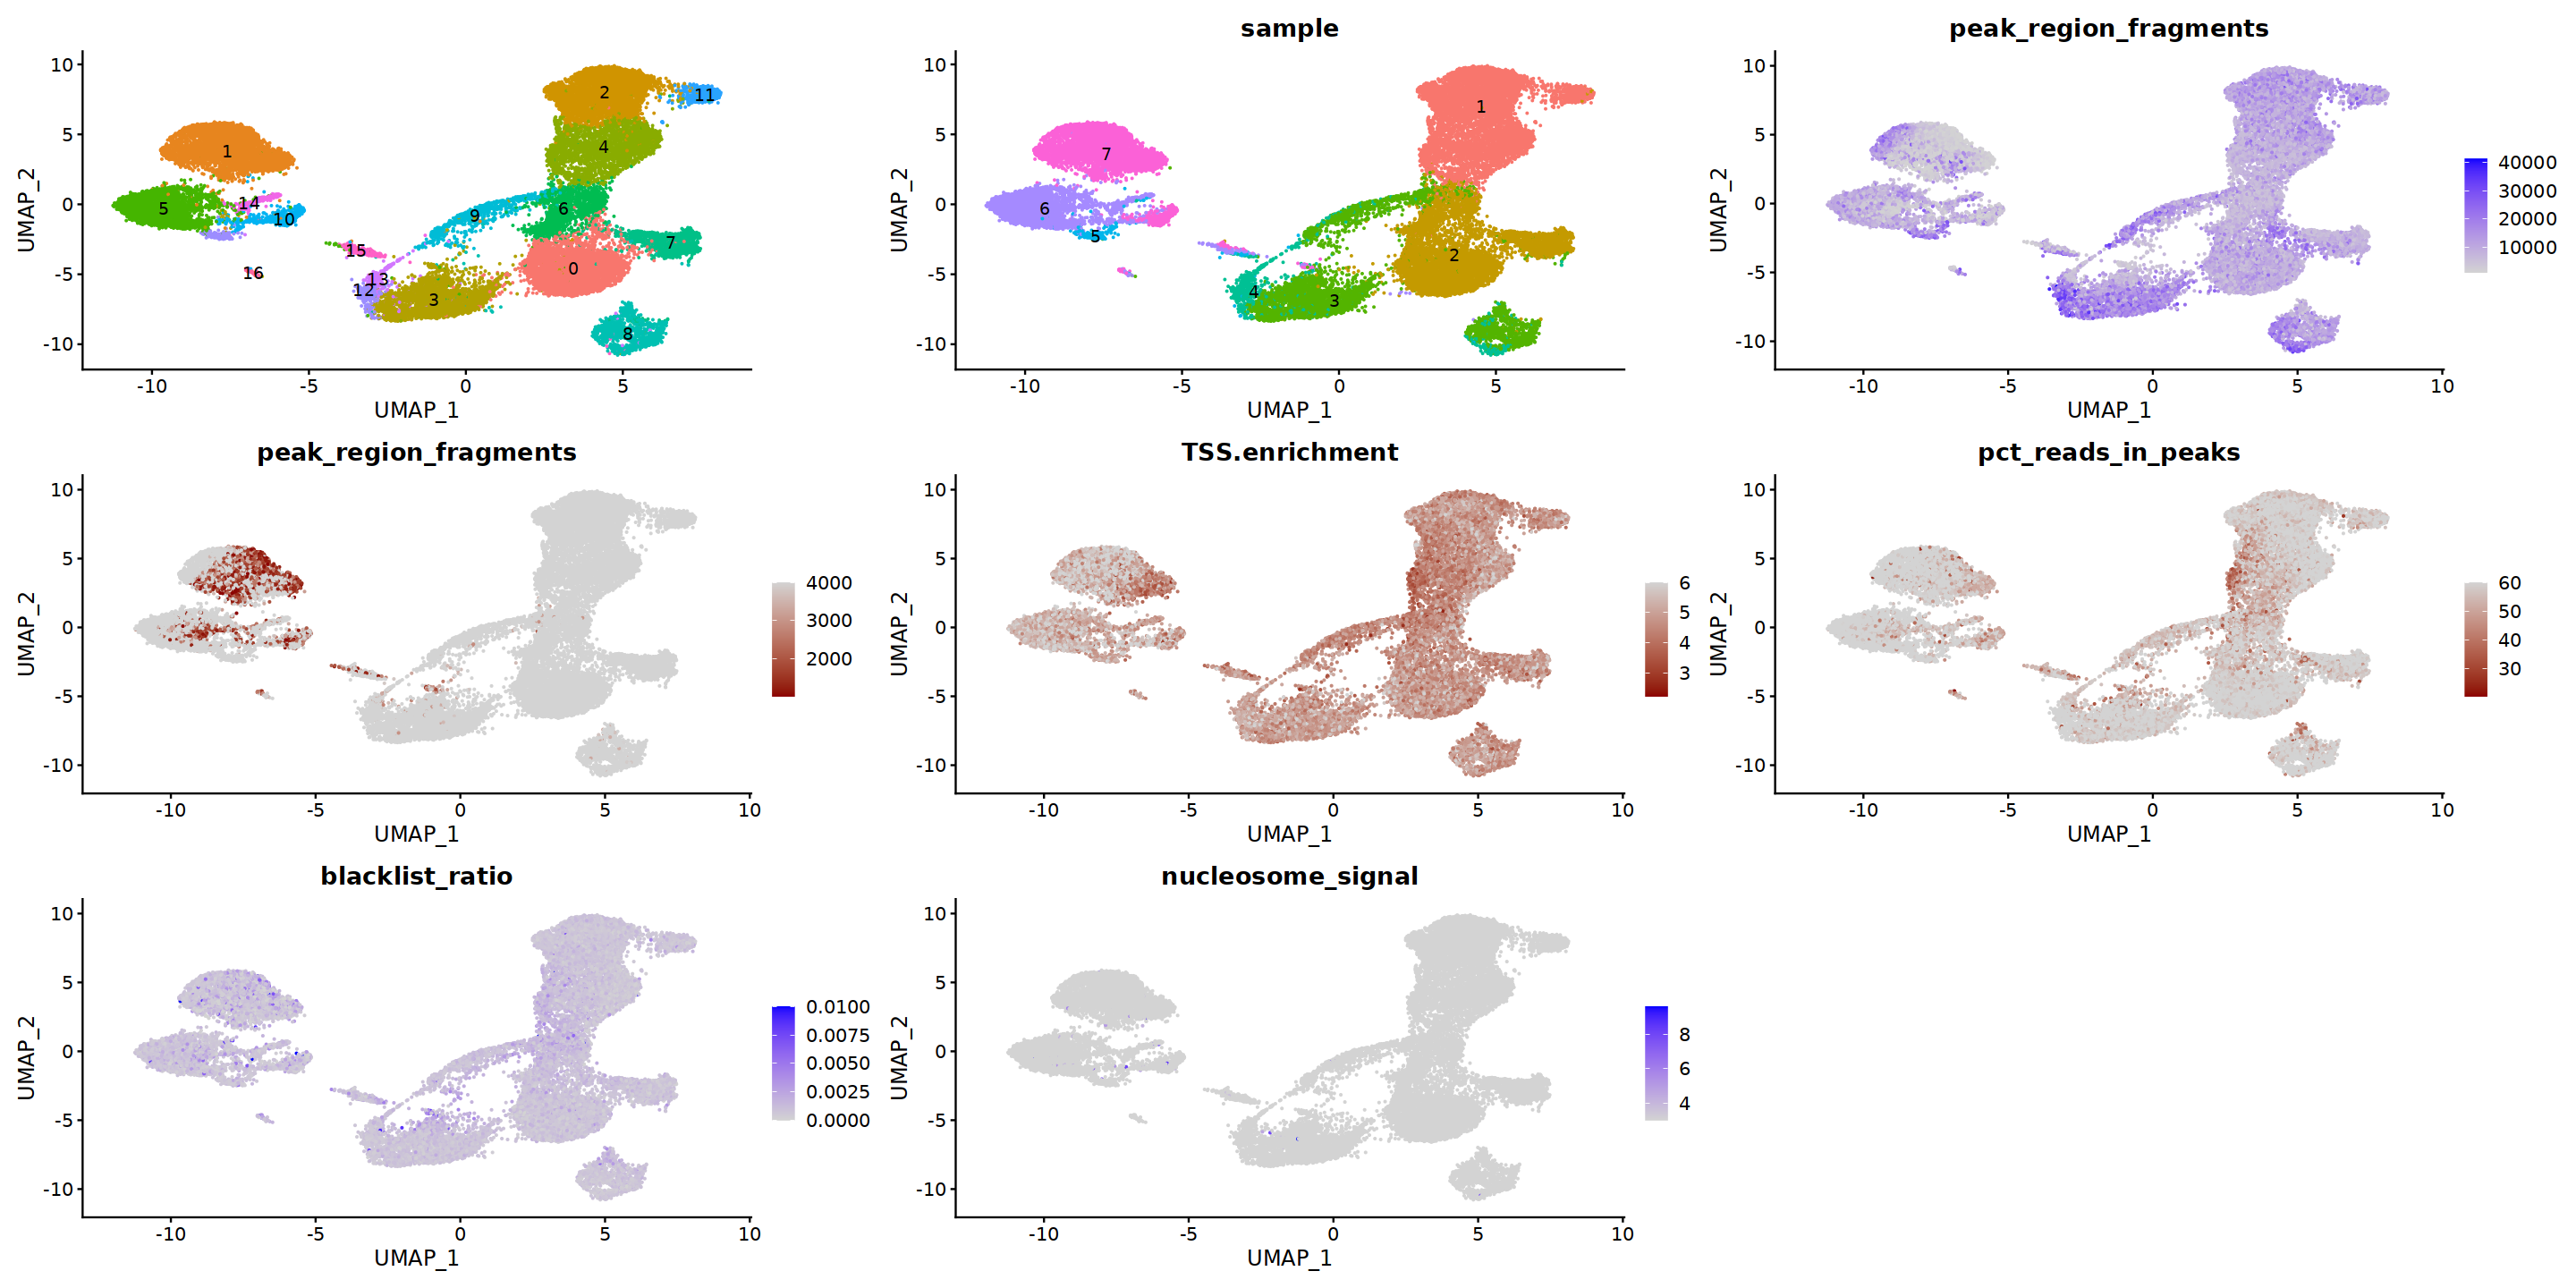

In [74]:
dimplot1 + dimplot2 + peak_frac_pl + peak_frac_low_pl + tss_pl + per_in_peak_pl + bl_pl + ns_pl

**^^Plot above:** Clear structure; high count cluster present (3) that has some cells sprinkeld across the UMAP. 

## Get gene activities

Now that we have filtered the cells and decided on a dimensionality reduced embedding, we add interpretability to our data by generating a gene activity matrix based on the peak matrix. (takes several monutes)

In [75]:
# select object to add gene activity
atac_selected <- atac_fltr_1

# Define lsi components that should be used for downstream processing
# Here, we will filter out the 1st and 4th LSI components whose absolute values of correlation coefficients were above 0.5
lsi_comps = c(2:40)

In [78]:
gene.activities <- GeneActivity(atac_selected)

Extracting gene coordinates

Extracting reads overlapping genomic regions



In [79]:
8

[1] 8

In [80]:
# add the gene activity matrix to the Seurat object as an RNA assay and normalize it
atac_selected[['RNA']] <- CreateAssayObject(counts = gene.activities)

Warning message:
"Non-unique features (rownames) present in the input matrix, making unique"


In [81]:
atac_selected <- NormalizeData(
  object = atac_selected,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(atac_selected$nCount_RNA)
)

### Save as R object

In [82]:
saveRDS(atac_selected, file = "/lustre/groups/ml01/workspace/laura.martens/moretti_colab/signac/atac_fltr_geneAct_unfiltered.rds")

In [4]:
# Loading
atac_selected <- readRDS(file = "/lustre/groups/ml01/workspace/laura.martens/moretti_colab/signac/atac_fltr_geneAct_unfiltered.rds")

In [5]:
atac_selected

An object of class Seurat 
182013 features across 27027 samples within 2 assays 
Active assay: peaks (162003 features, 162003 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: lsi, umap

# Create ChromVar activities

In [6]:
library(JASPAR2020)
library(TFBSTools)
library(BSgenome.Hsapiens.UCSC.hg19)
# Get a list of motif position frequency matrices from the JASPAR database
pfm <- getMatrixSet(
  x = JASPAR2020,
  opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE)
)



Loading required package: BSgenome

Loading required package: Biostrings

Loading required package: XVector


Attaching package: 'Biostrings'


The following object is masked from 'package:base':

    strsplit


Loading required package: rtracklayer



In [7]:
# add motif information
atac_selected <- AddMotifs(
  object = atac_selected,
  genome = BSgenome.Hsapiens.UCSC.hg19,
  pfm = pfm
)

Building motif matrix

Finding motif positions

Creating Motif object



In [8]:
atac <- RunChromVAR(object = atac_selected, genome = BSgenome.Hsapiens.UCSC.hg19)

Computing GC bias per region

Selecting background regions

Computing deviations from background

Constructing chromVAR assay



In [9]:
saveRDS(atac, file ='/lustre/groups/ml01/workspace/laura.martens/moretti_colab/signac/atac_final_unfiltered.rds')

In [10]:
atac_selected <- readRDS('/lustre/groups/ml01/workspace/laura.martens/moretti_colab/signac/atac_final_unfiltered.rds')

In [11]:
atac_selected

An object of class Seurat 
182759 features across 27027 samples within 3 assays 
Active assay: peaks (162003 features, 162003 variable features)
 2 other assays present: RNA, chromvar
 2 dimensional reductions calculated: lsi, umap

### Save as anndata

In [18]:
# Create adata - Gene activity in adata.X and peaks in adata.obsm
adata <- anndata::AnnData(X = t(atac_selected[['peaks']]@counts))

In [19]:
adata

AnnData object with n_obs × n_vars = 27027 × 162003

In [20]:
# Add meta data
adata$obs = atac_selected@meta.data

# Save binarized counts
adata$obsm[['activities']] <- t(atac_selected[['RNA']]@data)
adata$obsm[['chromvar']] <- t(atac_selected[['chromvar']]@data)

# Save LSI and UMAP embeddings
adata$obsm[['lsi_full']] <- Embeddings(atac_selected, reduction = "lsi")
adata$obsm[['lsi_red']] <- Embeddings(atac_selected, reduction = "lsi")[,c(2:40)]

adata$obsm[['umap']] <- Embeddings(atac_selected, reduction = "umap")


In [21]:
# Save peak names
adata$uns[['gene_names']] <- rownames(atac_selected[['RNA']]@data)
adata$uns[['motif_names']] <- rownames(atac_selected[['chromvar']]@data)

In [22]:
adata

AnnData object with n_obs × n_vars = 27027 × 162003
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'passed_filters', 'duplicate', 'cell_id', 'is__cell_barcode', 'TSS.enrichment', 'TSS.percentile', 'nucleosome_signal', 'nucleosome_percentile', 'pct_reads_in_peaks', 'blacklist_ratio', 'doublet_qvalue', 'is_doublet', 'peaks_snn_res.0.8', 'seurat_clusters', 'sample', 'nCount_RNA', 'nFeature_RNA'
    uns: 'gene_names', 'motif_names'
    obsm: 'activities', 'chromvar', 'lsi_full', 'lsi_red', 'umap'

In [23]:
# Save to disk 
adata$write_h5ad("/lustre/groups/ml01/workspace/laura.martens/moretti_colab/signac/adata_peaks_unfiltered.h5ad",
                compression = "gzip")

None

In [24]:
6

[1] 6

# Analyse ChromVar

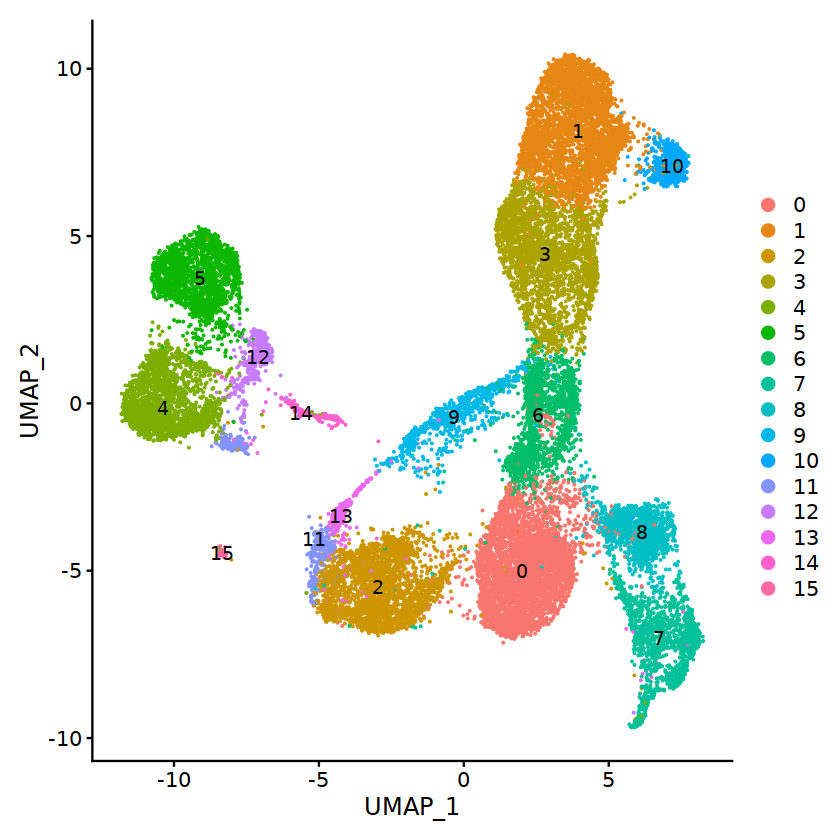

In [8]:
DimPlot(atac_selected, label=TRUE)

In [14]:
DefaultAssay(atac_selected) <- 'chromvar'

In [23]:
differential.activity <- FindMarkers(
  object = atac_selected,
  ident.1 = '12',
  ident.2 = '5',
  only.pos = TRUE,
  mean.fxn = rowMeans,
  fc.name = "avg_diff"
)

In [24]:
head(rownames(differential.activity))

[1] "MA0600.2" "MA0510.2" "MA0799.1" "MA1623.1" "MA1116.1" "MA0761.2"

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."


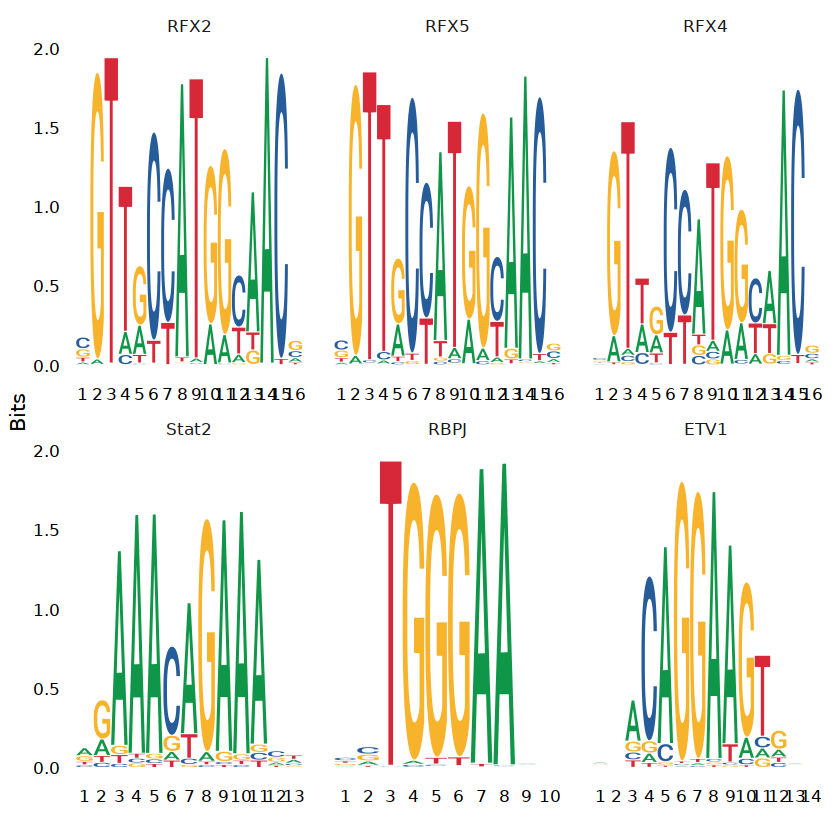

In [25]:
MotifPlot(
  object = atac_selected,
  motifs = head(rownames(differential.activity)),
  assay = 'peaks'
)

In [26]:
p2 <- FeaturePlot(
  object = atac_selected,
  features = 'MA0600.2',
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1
)

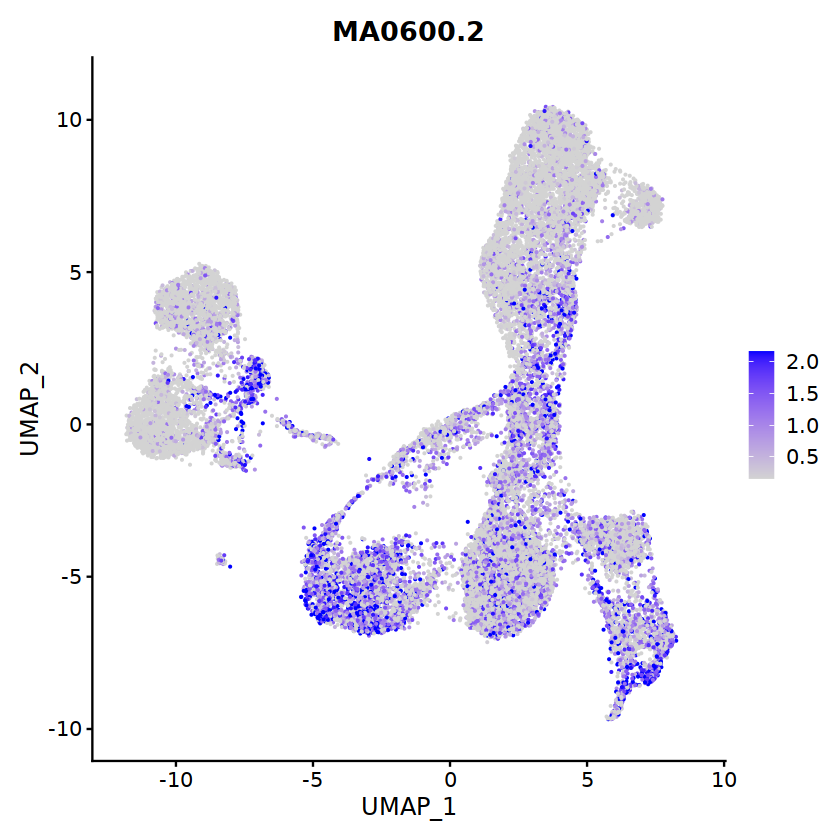

In [27]:
p2